<a href="https://colab.research.google.com/github/andres-gv/Statistics-R/blob/master/mercadolibre_API_categorias_items_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## API mercadolibre
Utilizando la metadata de los artículos publicados en mercadolibre, en este éste notebook se implementaron dos tareas: 

1. Exploracion y analisis preliminar de los datos
2. Construcción de un modelo predictivo para estimar la variable **sold_quantity**

La data fuente fue descargada a traves de la [API](https://developers.mercadolibre.com.ar/es_ar/api-docs-es) de mercadolibre, utilizando los endpoints: "category", "item", "metrics" y "users".

Resultados:




In [ ]:
# pip install ipywidgets
# import chart_studio.plotly as py
import json
import requests
import pandas as pd
from pandas import json_normalize
import plotly
import plotly.express as px
from plotly.offline import plot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# env settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
#pd.set_option('max_colwidth', None)
pd.reset_option('max_colwidth')

# if using a Jupyter notebook, includue:
#!jupyter nbextension enable --py widgetsnbextension

In [ ]:
# Definicion de funciones

# 1 json parsing
def jprint(obj):
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)
# 2 merge Dataframe from Series
def series_to_df(serie_aux):
  serie_df = pd.DataFrame([])
  for sx in range(0, serie_aux.size):
    serie_df = serie_df.append(serie_aux[sx])
  return serie_df

#-------------------------------------------------------------------
# 2 descarga de articulos por categoria, incluyendo offset
def get_cat_articulos(api_offset, categoria_id):
    endp = 'https://api.mercadolibre.com/sites/MCO/search?category=' + categoria_id + '&limit=50' + '&offset=' + str(api_offset)
    #endp = 'https://api.mercadolibre.com/sites/MCO/search?category=' + 'MCO1051' + '&limit=50' + '&offset=0'
    resp_api = requests.get(endp)
    #print(resp_api)
    if resp_api.status_code==200:
        #resp_tb = json_normalize(resp_api.json())
        resp_tb = json_normalize(data=resp_api.json(), record_path = 'results')
        #resp_tb = resp_tb.rename(columns = {'seller.id':'seller_id'})
        return resp_tb
    else:
        return 'error'

def get_cat_articulos_format(category_tb):
  seller_tb_f2 = category_tb.copy(deep = True) 
  seller_tb_f2.columns = seller_tb_f2.columns.str.replace(".", "_")
  seller_tb_f2.columns = seller_tb_f2.columns.str.replace("body_", "endp_category_")
  seller_tb_f2 = seller_tb_f2.rename(columns={'endp_category_id' : 'category_id', 'id':'item_id'}) 
  return seller_tb_f2     



# 3 descarga de informacion de item con multiget
def get_item_info(item_ids):
  #endpx = 'https://api.mercadolibre.com/items?ids=MCO575840605,MCO446772225'
  endpf = 'https://api.mercadolibre.com/items?ids=' + item_ids
  resp_api_fx = requests.get(endpf)
  if resp_api_fx.status_code==200:
    resp_tb = json_normalize( resp_api_fx.json())
    return resp_tb
  else:
    return 'error'

def get_item_info_format(articulos_tb):
  seller_tb_f2 = articulos_tb.copy(deep = True) 
  seller_tb_f2.columns = seller_tb_f2.columns.str.replace(".", "_")
  seller_tb_f2.columns = seller_tb_f2.columns.str.replace("body_", "endp_items_")
  seller_tb_f2 = seller_tb_f2.rename(columns={'endp_items_id' : 'item_id'}) 
  return seller_tb_f2     



# 4 descarga de informacion de usuario
def get_seller_info(user_ids):  
  endpf2 = 'https://api.mercadolibre.com/users?ids=' + user_ids
  resp_api_fx2 = requests.get(endpf2)
  if resp_api_fx2.status_code==200:
    resp_tb2 = json_normalize( resp_api_fx2.json())
    #resp_tb3 = resp_tb2[ ['body.id', 'body.nickname', 'body.registration_date',
    #   'body.country_id', 'body.address.city', 'body.address.state',
    #   'body.user_type', 'body.tags', 'body.points',
    #   'body.seller_reputation.level_id',
    #   'body.seller_reputation.power_seller_status',
    #   'body.seller_reputation.transactions.canceled',
    #   'body.seller_reputation.transactions.completed',
    #   'body.seller_reputation.transactions.period',
    #   'body.seller_reputation.transactions.ratings.negative',
    #   'body.seller_reputation.transactions.ratings.neutral',
    #   'body.seller_reputation.transactions.ratings.positive',
    #   'body.seller_reputation.transactions.total',
    #   'body.buyer_reputation.tags', 'body.status.site_status'] ]
    #resp_tb3 = resp_tb3.rename(columns={'body.id' : 'seller_id'}) 
    return resp_tb2
  else:
    return 'error'

def get_seller_info_format(seller_tb_f):
  seller_tb_f2 = seller_tb_f.copy(deep = True)[ ['body.id', 'body.nickname', 'body.registration_date',
       'body.country_id', 'body.address.city', 'body.address.state',
       'body.user_type', 'body.tags', 'body.points',
       'body.seller_reputation.level_id',
       'body.seller_reputation.power_seller_status',
       'body.seller_reputation.transactions.canceled',
       'body.seller_reputation.transactions.completed',
       'body.seller_reputation.transactions.period',
       'body.seller_reputation.transactions.ratings.negative',
       'body.seller_reputation.transactions.ratings.neutral',
       'body.seller_reputation.transactions.ratings.positive',
       'body.seller_reputation.transactions.total',
       'body.buyer_reputation.tags', 'body.status.site_status'] ]  
  seller_tb_f2.columns = seller_tb_f2.columns.str.replace(".", "_")
  seller_tb_f2.columns = seller_tb_f2.columns.str.replace("body_", "endp_users_")
  seller_tb_f2 = seller_tb_f2.rename(columns={'endp_users_id' : 'seller_id'}) 
  return seller_tb_f2 

# 5 descarga de metricas

def get_cat_articulos_1000(offset_param, cat_C0_tb_fx):
  cat_articulos_1000 = pd.DataFrame()
  for cat_id in cat_C0_tb_fx.category_id_list:
# cat_articulos_1000 = pd.DataFrame(fun_cat_articulos(0, 'MCO1051'))    
    for x in offset_param.offset:
      #cat_articulos_aux = pd.DataFrame(fun_cat_articulos(x, 'MCO1051'))
      cat_articulos_aux = get_cat_articulos(x, cat_id)
      cat_articulos_aux['category_id_list'] = cat_id
      if(isinstance(cat_articulos_aux, pd.DataFrame)):
        cat_articulos_1000 = cat_articulos_1000.append(cat_articulos_aux, ignore_index=True)
        #print(x)
           #print(cat_articulos_aux.shape)
      else:
        break
    print(str(cat_articulos_1000.shape) + " " + cat_id)
  return cat_articulos_1000




# 1 Data extraction

### 1.1 Data extraction




In [ ]:
# 1 Lista de sitios
resp = requests.get("https://api.mercadolibre.com/sites/")
print(resp.status_code )
#jprint(resp.json( ))
sites_list = json_normalize(resp.json())
sites_list.head(5)
#sites_list.style.apply(highlight_max, color='darkorange', axis=None)

200


default_currency_id   id       name
0                 BOB  MBO    Bolivia
1                 PYG  MPY   Paraguay
2                 NIO  MNI  Nicaragua
3                 MXN  MLM     Mexico
4                 GTQ  MGT  Guatemala

In [ ]:
# 2 categorias-CO
cat_CO = requests.get('https://api.mercadolibre.com/sites/MCO/categories')
cat_C0_tb = json_normalize(cat_CO.json())
print(cat_C0_tb.shape)
cat_C0_tb = cat_C0_tb.rename(columns={'id':'category_id_list','name': 'category_name'})
cat_C0_tb.head(100)

(31, 2)


category_id_list                   category_name
0           MCO1747       Accesorios para Vehículos
1         MCO441917                            Agro
2           MCO1403             Alimentos y Bebidas
3           MCO1071             Animales y Mascotas
4           MCO1367      Antigüedades y Colecciones
5           MCO1368      Arte, Papelería y Mercería
6           MCO1384                           Bebés
7           MCO1246      Belleza y Cuidado Personal
8          MCO40433       Boletas para Espectáculos
9           MCO1039            Cámaras y Accesorios
10          MCO1743           Carros, Motos y Otros
11          MCO1051           Celulares y Teléfonos
12          MCO1648                     Computación
13          MCO1144          Consolas y Videojuegos
14          MCO1276              Deportes y Fitness
15          MCO5726               Electrodomésticos
16          MCO1000      Electrónica, Audio y Video
17        MCO175794     Herramientas y Construcción
18          MCO1574                 Hogar y Muebles
19          MCO1499           Industrias y Oficinas
20          MCO1459                       Inmuebles
21          MCO1182          Instrumentos Musicales
22          MCO1132               Juegos y Juguetes
23          MCO3025       Libros, Revistas y Comics
24          MCO1168      Música, Películas y Series
25        MCO118204  Recuerdos, Piñatería y Fiestas
26          MCO3937                 Relojes y Joyas
27          MCO1430               Ropa y Accesorios
28        MCO180800     Salud y Equipamiento Médico
29          MCO1540                       Servicios
30          MCO1953                Otras categorías

In [ ]:
# 1 items x categorias 
offset_tb_aux = pd.DataFrame({'offset': range(0,150,50)})
cat_articulos_1000 = get_cat_articulos_1000(offset_tb_aux, cat_C0_tb)
cat_articulos_1000.shape
# get_seller_info_format(seller_data)
cat_articulos_1000_2 = get_cat_articulos_format(cat_articulos_1000)
cat_articulos_1000_2.head(2)

(150, 56) MCO1747
(300, 57) MCO441917
(450, 57) MCO1403
(600, 57) MCO1071
(750, 57) MCO1367
(900, 57) MCO1368
(1050, 57) MCO1384
(1200, 57) MCO1246
(1350, 57) MCO40433
(1500, 57) MCO1039
(1650, 112) MCO1743
(1798, 112) MCO1051
(1948, 112) MCO1648
(2098, 112) MCO1144
(2248, 112) MCO1276
(2398, 112) MCO5726
(2548, 112) MCO1000
(2698, 112) MCO175794
(2848, 112) MCO1574
(2998, 112) MCO1499
(3148, 115) MCO1459
(3298, 115) MCO1182
(3448, 115) MCO1132
(3598, 115) MCO3025
(3748, 116) MCO1168
(3898, 116) MCO118204
(4047, 116) MCO3937
(4197, 116) MCO1430
(4347, 116) MCO180800
(4497, 116) MCO1540
(4647, 116) MCO1953


item_id site_id                                              title  \
0  MCO548989931     MCO  Espejo Retrovisor Punto Ciego 360 Grados  - 2 ...   
1  MCO464935021     MCO  Kit Panel Solar+4 Bombillos+batería+linterna A...   

     price sale_price currency_id  available_quantity  sold_quantity  \
0  11000.0       None         COP                  50            250   
1  74900.0       None         COP                 100            500   

  buying_mode listing_type_id                 stop_time condition  \
0  buy_it_now    gold_special  2040-01-11T04:00:00.000Z       new   
1  buy_it_now    gold_special  2038-03-16T14:32:06.000Z       new   

                                           permalink  \
0  https://articulo.mercadolibre.com.co/MCO-54898...   
1  https://articulo.mercadolibre.com.co/MCO-46493...   

                                           thumbnail  accepts_mercadopago  \
0  http://mco-s2-p.mlstatic.com/917826-MCO4028726...                 True   
1  http://mco-s2-p.mlstatic.com/697242-MCO4022453...                 True   

                                          attributes original_price  \
0  [{'source': 8342579661593500, 'id': 'BRAND', '...            NaN   
1  [{'id': 'BRAND', 'values': [{'name': 'KILLO', ...          83900   

  category_id official_store_id                domain_id catalog_product_id  \
0   MCO174843               NaN        MCO-VEHICLE_PARTS               None   
1    MCO87923               NaN  MCO-VEHICLE_ACCESSORIES               None   

                                                tags  order_backend  \
0  [good_quality_picture, good_quality_thumbnail,...              1   
1  [good_quality_picture, good_quality_thumbnail,...              2   

   seller_id seller_permalink seller_registration_date  seller_car_dealer  \
0  145181776             None                     None              False   
1   62840024             None                     None              False   

   seller_real_estate_agency seller_tags  installments_quantity  \
0                      False        None                   36.0   
1                      False        None                   36.0   

   installments_amount  installments_rate installments_currency_id  \
0               305.56                0.0                      COP   
1              2080.56                0.0                      COP   

  address_state_id address_state_name   address_city_id address_city_name  \
0           CO-ANT          Antioquia  TUNPQ01FRGRjNjc4          Medellín   
1            CO-DC        Bogotá D.C.  TUNPQ01BUjU5NzU1          Martires   

   shipping_free_shipping shipping_mode  \
0                   False           me2   
1                    True           me2   

                                shipping_tags shipping_logistic_type  \
0                               [fulfillment]            fulfillment   
1  [self_service_in, mandatory_free_shipping]          cross_docking   

   shipping_store_pick_up seller_address_id seller_address_comment  \
0                   False                                            
1                   False                                            

  seller_address_address_line seller_address_zip_code  \
0                                                       
1                                                       

  seller_address_country_id seller_address_country_name  \
0                        CO                    Colombia   
1                        CO                    Colombia   

  seller_address_state_id seller_address_state_name seller_address_city_id  \
0                  CO-ANT                 Antioquia       TUNPQ01FRGRjNjc4   
1                   CO-DC               Bogotá D.C.       TUNPQ01BUjU5NzU1   

  seller_address_city_name seller_address_latitude seller_address_longitude  \
0                 Medellín                                                    
1                 Martires                                                    

   differential_pricing

In [ ]:
# 2 seller info 
seller_lists_aux = cat_articulos_1000_2['seller_id'].unique()
seller_lists_aux = seller_lists_aux.astype('str')
print(len(seller_lists_aux))
seller_lists_aux3 = seller_lists_aux[1:20]
seller_list_tb = pd.DataFrame(seller_lists_aux3)
seller_list_tb.columns = ['seller_id_key']
#seller_list_tb.seller_id_key.map()
seller_data0 = seller_list_tb.seller_id_key.apply(get_seller_info) #vectorized
seller_data = series_to_df(seller_data0)
print(seller_data.shape)
#seller_data.columns  #.colnames()
#seller_data.head(3)
seller_data_2 = get_seller_info_format(seller_data)
seller_data_2.head(2)

1787
(19, 24)


seller_id endp_users_nickname   endp_users_registration_date  \
0   62840024       YESICA ALZATE  2009-01-05T21:21:31.000-04:00   
0  212962423   WWW.BIG44SALE.COM  2016-05-02T23:39:21.000-04:00   

  endp_users_country_id endp_users_address_city endp_users_address_state  \
0                    CO                Martires                    CO-DC   
0                    CO                    Cali                   CO-VAC   

  endp_users_user_type   endp_users_tags  endp_users_points  \
0               normal   [normal, eshop]              10446   
0               normal  [normal, mshops]               2678   

  endp_users_seller_reputation_level_id  \
0                               5_green   
0                               5_green   

  endp_users_seller_reputation_power_seller_status  \
0                                         platinum   
0                                         platinum   

   endp_users_seller_reputation_transactions_canceled  \
0                                               1605    
0                                                479    

   endp_users_seller_reputation_transactions_completed  \
0                                              46275     
0                                              13071     

  endp_users_seller_reputation_transactions_period  \
0                                         historic   
0                                         historic   

   endp_users_seller_reputation_transactions_ratings_negative  \
0                                               0.03            
0                                               0.00            

   endp_users_seller_reputation_transactions_ratings_neutral  \
0                                               0.03           
0                                               0.00           

   endp_users_seller_reputation_transactions_ratings_positive  \
0                                               0.94            
0                                               1.00            

   endp_users_seller_reputation_transactions_total  \
0                                            47880   
0                                            13550   

  endp_users_buyer_reputation_tags endp_users_status_site_status  
0                               []                        active  
0                               []                        active

In [ ]:
# 3 item info
#cat_articulos_1000_full_data()
print(cat_articulos_1000_2.item_id.nunique())
items_list = cat_articulos_1000_2.item_id[0:3]
#items_list
items_tb0 = items_list.apply(get_item_info)
items_tb = series_to_df(items_tb0)
items_tb2 = get_item_info_format(items_tb)
print(items_tb2.shape)
items_tb2
#get_item_info(items_list[1])

4458
(3, 77)


code       item_id endp_items_site_id  \
0   200  MCO548989931                MCO   
0   200  MCO464935021                MCO   
0   200  MCO509093160                MCO   

                                    endp_items_title endp_items_subtitle  \
0  Espejo Retrovisor Punto Ciego 360 Grados  - 2 ...                None   
0  Kit Panel Solar+4 Bombillos+batería+linterna A...                None   
0  Radio Carro Bluetooth + Camara Usb Sd Pantalla...                None   

   endp_items_seller_id endp_items_category_id endp_items_official_store_id  \
0             145181776              MCO174843                         None   
0              62840024               MCO87923                         None   
0             212962423              MCO429530                         None   

   endp_items_price  endp_items_base_price endp_items_original_price  \
0             11000                  11000                      None   
0             74900                  74900                     83900   
0            189900                 189900                    399900   

  endp_items_currency_id  endp_items_initial_quantity  \
0                    COP                          423   
0                    COP                         2875   
0                    COP                         3606   

   endp_items_available_quantity  endp_items_sold_quantity  \
0                             50                       250   
0                            100                       500   
0                              1                       500   

                               endp_items_sale_terms endp_items_buying_mode  \
0  [{'id': 'WARRANTY_TYPE', 'name': 'Tipo de gara...             buy_it_now   
0  [{'id': 'WARRANTY_TYPE', 'name': 'Tipo de gara...             buy_it_now   
0  [{'id': 'WARRANTY_TYPE', 'name': 'Tipo de gara...             buy_it_now   

  endp_items_listing_type_id     endp_items_start_time  \
0               gold_special  2020-01-16T17:54:27.000Z   
0               gold_special  2018-02-20T23:01:57.000Z   
0               gold_special  2019-04-07T20:33:15.000Z   

       endp_items_stop_time endp_items_condition  \
0  2040-01-11T04:00:00.000Z                  new   
0  2038-03-16T14:32:06.000Z                  new   
0  2039-04-02T04:00:00.000Z                  new   

                                endp_items_permalink  \
0  https://articulo.mercadolibre.com.co/MCO-54898...   
0  https://articulo.mercadolibre.com.co/MCO-46493...   
0  https://articulo.mercadolibre.com.co/MCO-50909...   

        endp_items_thumbnail_id  \
0  917826-MCO40287266098_122019   
0  697242-MCO40224532070_122019   
0  768065-MCO42461943820_072020   

                                endp_items_thumbnail  \
0  http://mco-s2-p.mlstatic.com/917826-MCO4028726...   
0  http://mco-s2-p.mlstatic.com/697242-MCO4022453...   
0  http://mco-s1-p.mlstatic.com/768065-MCO4246194...   

                         endp_items_secure_thumbnail  \
0  https://mco-s2-p.mlstatic.com/917826-MCO402872...   
0  https://mco-s2-p.mlstatic.com/697242-MCO402245...   
0  https://mco-s1-p.mlstatic.com/768065-MCO424619...   

                                 endp_items_pictures endp_items_video_id  \
0  [{'id': '917826-MCO40287266098_122019', 'url':...                None   
0  [{'id': '697242-MCO40224532070_122019', 'url':...                None   
0  [{'id': '768065-MCO42461943820_072020', 'url':...         TzMT56-P62w   

               endp_items_descriptions  endp_items_accepts_mercadopago  \
0  [{'id': 'MCO548989931-2472852453'}]                            True   
0  [{'id': 'MCO464935021-1582598799'}]                            True   
0  [{'id': 'MCO509093160-2046028189'}]                            True   

  endp_items_non_mercado_pago_payment_methods endp_items_shipping_mode  \
0                                          []                      me2   
0                                          []                      me2   
0                                     

In [ ]:
# 4 full join
cat_articulos_1000_full_data0 = pd.merge(cat_articulos_1000_2, seller_data_2, on='seller_id', how='left' )
cat_articulos_1000_full_data = pd.merge(cat_articulos_1000_full_data0, items_tb2, on="item_id", how='left')

#print(cat_articulos_1000.shape)
print(cat_articulos_1000_full_data.shape)
cat_articulos_1000_full_data.head(2)

(4647, 211)


item_id site_id                                              title  \
0  MCO548989931     MCO  Espejo Retrovisor Punto Ciego 360 Grados  - 2 ...   
1  MCO464935021     MCO  Kit Panel Solar+4 Bombillos+batería+linterna A...   

     price sale_price currency_id  available_quantity  sold_quantity  \
0  11000.0       None         COP                  50            250   
1  74900.0       None         COP                 100            500   

  buying_mode listing_type_id                 stop_time condition  \
0  buy_it_now    gold_special  2040-01-11T04:00:00.000Z       new   
1  buy_it_now    gold_special  2038-03-16T14:32:06.000Z       new   

                                           permalink  \
0  https://articulo.mercadolibre.com.co/MCO-54898...   
1  https://articulo.mercadolibre.com.co/MCO-46493...   

                                           thumbnail  accepts_mercadopago  \
0  http://mco-s2-p.mlstatic.com/917826-MCO4028726...                 True   
1  http://mco-s2-p.mlstatic.com/697242-MCO4022453...                 True   

                                          attributes original_price  \
0  [{'source': 8342579661593500, 'id': 'BRAND', '...            NaN   
1  [{'id': 'BRAND', 'values': [{'name': 'KILLO', ...          83900   

  category_id official_store_id                domain_id catalog_product_id  \
0   MCO174843               NaN        MCO-VEHICLE_PARTS               None   
1    MCO87923               NaN  MCO-VEHICLE_ACCESSORIES               None   

                                                tags  order_backend  \
0  [good_quality_picture, good_quality_thumbnail,...              1   
1  [good_quality_picture, good_quality_thumbnail,...              2   

   seller_id seller_permalink seller_registration_date  seller_car_dealer  \
0  145181776             None                     None              False   
1   62840024             None                     None              False   

   seller_real_estate_agency seller_tags  installments_quantity  \
0                      False        None                   36.0   
1                      False        None                   36.0   

   installments_amount  installments_rate installments_currency_id  \
0               305.56                0.0                      COP   
1              2080.56                0.0                      COP   

  address_state_id address_state_name   address_city_id address_city_name  \
0           CO-ANT          Antioquia  TUNPQ01FRGRjNjc4          Medellín   
1            CO-DC        Bogotá D.C.  TUNPQ01BUjU5NzU1          Martires   

   shipping_free_shipping shipping_mode  \
0                   False           me2   
1                    True           me2   

                                shipping_tags shipping_logistic_type  \
0                               [fulfillment]            fulfillment   
1  [self_service_in, mandatory_free_shipping]          cross_docking   

   shipping_store_pick_up seller_address_id seller_address_comment  \
0                   False                                            
1                   False                                            

  seller_address_address_line seller_address_zip_code  \
0                                                       
1                                                       

  seller_address_country_id seller_address_country_name  \
0                        CO                    Colombia   
1                        CO                    Colombia   

  seller_address_state_id seller_address_state_name seller_address_city_id  \
0                  CO-ANT                 Antioquia       TUNPQ01FRGRjNjc4   
1                   CO-DC               Bogotá D.C.       TUNPQ01BUjU5NzU1   

  seller_address_city_name seller_address_latitude seller_address_longitude  \
0                 Medellín                                                    
1                 Martires                                                    

   differential_pricing

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
#pd.set_option('max_colwidth', None)
pd.reset_option('max_colwidth')

# funciones
def jprint(obj):
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)
    
#def fun_cat_articulos( api_offset, categoria_id):
def fun_cat_articulos(api_offset, categoria_id):
    endp = 'https://api.mercadolibre.com/sites/MCO/search?category=' + categoria_id + '&limit=50' + '&offset=' + str(api_offset)
    #endp = 'https://api.mercadolibre.com/sites/MCO/search?category=' + 'MCO1051' + '&limit=50' + '&offset=0'
    resp_api = requests.get(endp)
    #print(resp_api)
    if resp_api.status_code==200:
        #resp_tb = json_normalize(resp_api.json())
        resp_tb = json_normalize(data=resp_api.json(), record_path = 'results')
        return resp_tb
    else:
        return 'error'

In [ ]:
# 1 Sites
resp = requests.get("https://api.mercadolibre.com/sites/")
print(resp.status_code )
#jprint(resp.json( ))
json_normalize(resp.json()).head(5)

200


default_currency_id   id        name
0                 VES  MLV   Venezuela
1                 COP  MCO    Colombia
2                 CRC  MCR  Costa Rica
3                 PEN  MPE        Perú
4                 PYG  MPY    Paraguay

In [ ]:
# 2 categorias-CO
cat_CO = requests.get('https://api.mercadolibre.com/sites/MCO/categories')
cat_C0_tb = json_normalize(cat_CO.json())
print(cat_C0_tb.shape)
cat_C0_tb = cat_C0_tb.rename(columns={'id':'category_id_list','name': 'category_name'})
cat_C0_tb

(31, 2)


category_id_list                   category_name
0           MCO1747       Accesorios para Vehículos
1         MCO441917                            Agro
2           MCO1403             Alimentos y Bebidas
3           MCO1071             Animales y Mascotas
4           MCO1367      Antigüedades y Colecciones
5           MCO1368      Arte, Papelería y Mercería
6           MCO1384                           Bebés
7           MCO1246      Belleza y Cuidado Personal
8          MCO40433       Boletas para Espectáculos
9           MCO1039            Cámaras y Accesorios
10          MCO1743           Carros, Motos y Otros
11          MCO1051           Celulares y Teléfonos
12          MCO1648                     Computación
13          MCO1144          Consolas y Videojuegos
14          MCO1276              Deportes y Fitness
15          MCO5726               Electrodomésticos
16          MCO1000      Electrónica, Audio y Video
17        MCO175794     Herramientas y Construcción
18          MCO1574                 Hogar y Muebles
19          MCO1499           Industrias y Oficinas
20          MCO1459                       Inmuebles
21          MCO1182          Instrumentos Musicales
22          MCO1132               Juegos y Juguetes
23          MCO3025       Libros, Revistas y Comics
24          MCO1168      Música, Películas y Series
25        MCO118204  Recuerdos, Piñatería y Fiestas
26          MCO3937                 Relojes y Joyas
27          MCO1430               Ropa y Accesorios
28        MCO180800     Salud y Equipamiento Médico
29          MCO1540                       Servicios
30          MCO1953                Otras categorías

In [ ]:
# 2 Descarga de 1000-articulos por categoria, con el endpoint https://api.mercadolibre.com/sites/MCO/search?category


#offset_tb = pd.DataFrame({'offset': range(0,150,50),  'categoria_id': 'MCO1051'})

offset_tb = pd.DataFrame({'offset': range(0,500,50)})
#offset_tb
cat_articulos_1000 = pd.DataFrame()
for cat_id in cat_C0_tb.category_id_list:
#cat_articulos_1000 = pd.DataFrame(fun_cat_articulos(0, 'MCO1051'))    
    for x in offset_tb.offset:
        #cat_articulos_aux = pd.DataFrame(fun_cat_articulos(x, 'MCO1051'))
        cat_articulos_aux = fun_cat_articulos(x, cat_id)
        cat_articulos_aux['category_id_list'] = cat_id
        if(isinstance(cat_articulos_aux, pd.DataFrame)):
            cat_articulos_1000 = cat_articulos_1000.append(cat_articulos_aux, ignore_index=True)
            #print(x)
            #print(cat_articulos_aux.shape)
        else:
            break
    print(str(cat_articulos_1000.shape) + " " + cat_id)


(500, 57) MCO1747
(999, 57) MCO441917
(1499, 57) MCO1403
(1999, 57) MCO1071
(2499, 57) MCO1367
(2999, 57) MCO1368
(3499, 57) MCO1384
(3999, 57) MCO1246
(4499, 57) MCO40433
(4999, 57) MCO1039
(5499, 120) MCO1743
(5999, 120) MCO1051
(6499, 120) MCO1648
(6999, 120) MCO1144
(7499, 120) MCO1276
(7999, 120) MCO5726
(8499, 120) MCO1000
(8998, 120) MCO175794
(9495, 120) MCO1574
(9995, 120) MCO1499
(10495, 123) MCO1459
(10995, 123) MCO1182
(11495, 123) MCO1132
(11995, 123) MCO3025
(12495, 124) MCO1168
(12995, 124) MCO118204
(13494, 124) MCO3937
(13994, 124) MCO1430
(14494, 124) MCO180800
(14994, 124) MCO1540
(15494, 124) MCO1953


In [ ]:
print(cat_articulos_1000.shape)
print(cat_articulos_1000.domain_id.nunique())
print(cat_articulos_1000.category_id.nunique())
print(cat_articulos_1000.id.nunique())
#print(cat_articulos_1000.columns)
cat_articulos_1000.head(6)
#cat_articulos_1000['shipping.free_shipping']
#cat_articulos_1000

(12393, 124)
938
1291
11877


id site_id                                              title  \
0  MCO548989931     MCO  Espejo Retrovisor Punto Ciego 360 Grados  - 2 ...   
1  MCO464935021     MCO  Kit Panel Solar+4 Bombillos+batería+linterna A...   
2  MCO509093160     MCO  Radio Carro Bluetooth + Camara Usb Sd Pantalla...   
3  MCO551840617     MCO  2 Exploradoras 6 Led 12000lm 72w Fija Estrober...   
4  MCO575840605     MCO  Mascara Antipolucion Tapaboca Moto Balaclava C...   
5  MCO468073609     MCO  Limpiador De Inyectores De Motor A Gasolina Li...   

      price sale_price currency_id  available_quantity  sold_quantity  \
0   11000.0       None         COP                 100            250   
1   74900.0       None         COP                 150            500   
2  189900.0       None         COP                   1            500   
3   42900.0       None         COP                  50            250   
4    8500.0       None         COP                 100           5000   
5   32000.0       None         COP                 150            250   

  buying_mode listing_type_id                 stop_time condition  \
0  buy_it_now    gold_special  2040-01-11T04:00:00.000Z       new   
1  buy_it_now    gold_special  2038-03-16T14:32:06.000Z       new   
2  buy_it_now    gold_special  2039-04-02T04:00:00.000Z       new   
3  buy_it_now    gold_special  2040-08-14T19:04:39.000Z       new   
4  buy_it_now    gold_special  2040-08-03T04:00:00.000Z       new   
5  buy_it_now    gold_special  2040-07-12T22:08:56.000Z       new   

                                           permalink  \
0  https://articulo.mercadolibre.com.co/MCO-54898...   
1  https://articulo.mercadolibre.com.co/MCO-46493...   
2  https://articulo.mercadolibre.com.co/MCO-50909...   
3  https://articulo.mercadolibre.com.co/MCO-55184...   
4  https://articulo.mercadolibre.com.co/MCO-57584...   
5  https://articulo.mercadolibre.com.co/MCO-46807...   

                                           thumbnail  accepts_mercadopago  \
0  http://mco-s2-p.mlstatic.com/917826-MCO4028726...                 True   
1  http://mco-s2-p.mlstatic.com/697242-MCO4022453...                 True   
2  http://mco-s1-p.mlstatic.com/768065-MCO4246194...                 True   
3  http://mco-s2-p.mlstatic.com/943524-MCO4283305...                 True   
4  http://mco-s2-p.mlstatic.com/638925-MCO4361342...                 True   
5  http://mco-s2-p.mlstatic.com/681229-MCO3104189...                 True   

                                          attributes original_price  \
0  [{'id': 'BRAND', 'name': 'Marca', 'value_name'...            NaN   
1  [{'values': [{'id': None, 'name': 'KILLO', 'st...          83900   
2  [{'values': [{'struct': None, 'source': 1572, ...         399900   
3  [{'value_name': 'JDL', 'value_struct': None, '...          51900   
4  [{'value_id': '2230284', 'attribute_group_id':...           9900   
5  [{'value_id': '2786975', 'value_name': 'Liqui ...            NaN   

  category_id official_store_id                              domain_id  \
0   MCO174843               NaN                      MCO-VEHICLE_PARTS   
1    MCO87923               NaN                MCO-VEHICLE_ACCESSORIES   
2   MCO429530               NaN                MCO-VEHICLE_ACCESSORIES   
3    MCO90578               NaN                MCO-VEHICLE_ACCESSORIES   
4   MCO180743               NaN  MCO-NECK_GAITERS_MASKS_AND_BALACLAVAS   
5   MCO166028               NaN                     MCO-FUEL_INJECTORS   

  catalog_product_id                                               tags  \
0               None  [good_quality_picture, good_quality_thumbnail,...   
1               None  [good_quality_picture, good_quality_thumbnail,...   
2               None  [dragged_bids_and_visits, good_quality_picture...   
3               None  [good_quality_picture, good_quality_thumbnail,...   
4               None  [good_quality_thumbnail, dragged_bids_and_visi...   
5               None  [good_quality_picture, good_quality_thumbnail,..

In [ ]:
# 3 Items
endpx = 'https://api.mercadolibre.com/items/MCO575840605'
#endp = 'https://api.mercadolibre.com/sites/MCO/search?category=' + 'MCO1051' + '&limit=50' + '&offset=0'
resp_apix = requests.get(endpx)
json_normalize( resp_apix.json())

id site_id                                              title  \
0  MCO575840605     MCO  Mascara Antipolucion Tapaboca Moto Balaclava C...   

  subtitle  seller_id category_id official_store_id  price  base_price  \
0     None   62840024   MCO180743              None   8500        8500   

   original_price currency_id  initial_quantity  available_quantity  \
0            9900         COP               428                 100   

   sold_quantity                                         sale_terms  \
0           5000  [{'id': 'WARRANTY_TIME', 'name': 'Tiempo de ga...   

  buying_mode listing_type_id                start_time  \
0  buy_it_now    gold_special  2020-08-08T20:37:49.000Z   

                  stop_time condition  \
0  2040-08-03T04:00:00.000Z       new   

                                           permalink  \
0  https://articulo.mercadolibre.com.co/MCO-57584...   

                   thumbnail_id  \
0  638925-MCO43613426349_092020   

                                           thumbnail  \
0  http://mco-s2-p.mlstatic.com/638925-MCO4361342...   

                                    secure_thumbnail  \
0  https://mco-s2-p.mlstatic.com/638925-MCO436134...   

                                            pictures video_id  \
0  [{'id': '638925-MCO43613426349_092020', 'url':...     None   

                          descriptions  accepts_mercadopago  \
0  [{'id': 'MCO575840605-2845595352'}]                 True   

  non_mercado_pago_payment_methods international_delivery_mode seller_contact  \
0                               []                        none           None   

  coverage_areas                                         attributes warnings  \
0             []  [{'id': 'GTIN', 'name': 'Código universal de p...       []   

  listing_source variations  status sub_status  \
0                        []  active         []   

                                                tags  \
0  [dragged_bids_and_visits, good_quality_picture...   

                         warranty catalog_product_id  \
0  Garantía del vendedor: 3 meses               None   

                               domain_id parent_item_id differential_pricing  \
0  MCO-NECK_GAITERS_MASKS_AND_BALACLAVAS   MCO568798550                 None   

                               deal_ids  automatic_relist  \
0  [MCO1905, MCO1913, MCO1895, MCO1894]             False   

               date_created              last_updated  health  \
0  2020-08-08T20:37:49.000Z  2020-10-13T16:10:49.000Z    0.83   

   catalog_listing shipping.mode shipping.methods      shipping.tags  \
0            False           me2               []  [self_service_in]   

  shipping.dimensions  shipping.local_pick_up  shipping.free_shipping  \
0                None                   False                   False   

  shipping.logistic_type  shipping.store_pick_up seller_address.city.id  \
0            fulfillment                   False       TUNPQ01BUjU5NzU1   

  seller_address.city.name seller_address.state.id seller_address.state.name  \
0                 Martires                   CO-DC               Bogotá D.C.   

  seller_address.country.id seller_address.country.name  \
0                        CO                    Colombia   

  seller_address.search_location.city.id  \
0                       TUNPQ01BUjU5NzU1   

  seller_address.search_location.city.name  \
0                                 Martires   

  seller_address.search_location.state.id  \
0                      TUNPUEJPR1gxMDljZA   

  seller_address.search_location.state.name  seller_address.latitude  \
0                               Bogotá D.C.                  4.61202   

   seller_address.longitude  seller_address.id  geolocation.latitude  \
0                -74.087204         1127703636               4.61202   

   geolocation.longitude  
0             -74.087204

In [ ]:
#---- Descuento promedio x categoria ----
articulos_descuentos = cat_articulos_1000[cat_articulos_1000.original_price > 10]
articulos_descuentos_2 = articulos_descuentos[['price', 'category_id_list', 'original_price']]
articulos_descuentos_3 = pd.merge(articulos_descuentos_2,cat_C0_tb, on = 'category_id_list', how = 'left' )
articulos_descuentos_3['original_price'] = articulos_descuentos_3['original_price'].astype(float)
articulos_descuentos_3['descuento'] = articulos_descuentos_3.original_price - articulos_descuentos_3.price
#articulos_descuentos_3['original_price'] = float(articulos_descuentos_3.original_price)
#articulos_descuentos_4 = articulos_descuentos_3[['category_name', 'descuento']]
#mean(articulos_descuentos_3.descuento)
#articulos_descuentos_3.groupby('category_name').mean()#.sort_values('price', ascending=False)
#type(articulos_descuentos_3.price)
print(cat_C0_tb.category_id_list.nunique()  )
articulos_descuentos_3.groupby(['category_name'])['descuento'].agg(['mean', 'max', 'count']).sort_values('mean', ascending=False) # for count also consider 'size'. size will return n for NaN values also, whereas 'count' will not.
#print(articulos_descuentos_3.price.describe())
#print(articulos_descuentos_3.original_price.describe())
#print(articulos_descuentos_3.descuento.describe())

31


mean         max  count
category_name                                                  
Carros, Motos y Otros           1.350000e+07  13500000.0      1
Celulares y Teléfonos           3.386459e+05   1250000.0    141
Computación                     3.066984e+05   1850000.0     80
Cámaras y Accesorios            2.596991e+05   2000000.0     29
Consolas y Videojuegos          1.939896e+05    770100.0     98
Deportes y Fitness              1.892325e+05   1000000.0     55
Electrónica, Audio y Video      1.642356e+05   1430100.0     37
Relojes y Joyas                 1.600375e+05    350000.0      8
Instrumentos Musicales          1.344000e+05    539900.0     15
Electrodomésticos               1.241993e+05    666000.0     75
Hogar y Muebles                 1.171291e+05    614000.0     52
Agro                            9.701600e+04    190100.0     10
Industrias y Oficinas           9.624538e+04    400000.0     13
Bebés                           8.224955e+04   1452650.0     53
Juegos y Juguetes               6.064923e+04   1501000.0     82
Belleza y Cuidado Personal      5.731450e+04    269850.0     30
Salud y Equipamiento Médico     4.529492e+04    211000.0     24
Accesorios para Vehículos       4.335489e+04    400000.0     92
Herramientas y Construcción     2.938300e+04    150000.0     28
Ropa y Accesorios               2.377500e+04     50000.0     10
Animales y Mascotas             1.990530e+04     62800.0     47
Música, Películas y Series      1.952857e+04    100000.0     35
Alimentos y Bebidas             1.338732e+04     34000.0     38
Arte, Papelería y Mercería      6.851515e+03     20000.0     33
Antigüedades y Colecciones      1.600000e+03      1600.0      1
Recuerdos, Piñatería y Fiestas  1.300000e+03      1300.0      1

In [ ]:
#---- Descuento promedio x categoria ----
articulos_descuentos = cat_articulos_1000[cat_articulos_1000.original_price > 10]
articulos_descuentos_2 = articulos_descuentos[['price', 'domain_id', 'original_price']]
#articulos_descuentos_3 = pd.merge(articulos_descuentos_2,cat_C0_tb, on = 'domain_id', how = 'left' )
articulos_descuentos_3 = articulos_descuentos_2
articulos_descuentos_3['original_price'] = articulos_descuentos_3['original_price'].astype(float)
articulos_descuentos_3['descuento'] = articulos_descuentos_3.original_price - articulos_descuentos_3.price
#articulos_descuentos_3['original_price'] = float(articulos_descuentos_3.original_price)
#articulos_descuentos_4 = articulos_descuentos_3[['category_name', 'descuento']]
#mean(articulos_descuentos_3.descuento)
#articulos_descuentos_3.groupby('category_name').mean()#.sort_values('price', ascending=False)
#type(articulos_descuentos_3.price)
articulos_descuentos_4 = articulos_descuentos_3.groupby(['domain_id'])['descuento'].agg(['mean', 'max', 'count']).sort_values('count', ascending=False) # for count also consider 'size'. size will return n for NaN values also, whereas 'count' will not.
#len(articulos_descuentos_4.index)
articulos_descuentos_4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



mean        max  count
domain_id                                                 
MCO-CELLPHONES             349786.022059  1250000.0    136
MCO-GAME_CONSOLES          265956.065574   770100.0     61
MCO-VEHICLE_ACCESSORIES     63488.604651   400000.0     43
MCO-CATS_AND_DOGS_FOODS     21837.682927    62800.0     41
MCO-MOVIES                  20011.764706   100000.0     34
...                                  ...        ...    ...
MCO-KITCHEN_COOKWARE_SETS  550100.000000   550100.0      1
MCO-CELL_BATTERIES            800.000000      800.0      1
MCO-JUMP_ROPES               3960.000000     3960.0      1
MCO-JUICERS                 70100.000000    70100.0      1
MCO-HANDBAGS                50000.000000    50000.0      1

[234 rows x 3 columns]

In [ ]:
#left_join_df= pd.merge(df1, df2, on='Customer_id', how='left')
#left_join_df 
cat_articulos_1000_2 = cat_articulos_1000[cat_articulos_1000.price < 1e8]
cat_articulos_1000_3 = cat_articulos_1000_2[['price', 'category_id_list']]
cat_articulos_1000_4 = pd.merge(cat_articulos_1000_3,cat_C0_tb, on = 'category_id_list', how = 'left' )
#cat_articulos_1000_5 = cat_articulos_1000_4[cat_articulos_1000.price < 1e8]
#cat_articulos_1000_5.price.describe()
#cat_articulos_1000_4 = cat_articulos_1000_3[['price', 'category_id']]
cat_articulos_1000_4

price category_id_list              category_name
0       11000.0          MCO1747  Accesorios para Vehículos
1       74900.0          MCO1747  Accesorios para Vehículos
2      189900.0          MCO1747  Accesorios para Vehículos
3       42900.0          MCO1747  Accesorios para Vehículos
4        8500.0          MCO1747  Accesorios para Vehículos
...         ...              ...                        ...
11815   15000.0          MCO1953           Otras categorías
11816   33200.0          MCO1953           Otras categorías
11817   26500.0          MCO1953           Otras categorías
11818   26900.0          MCO1953           Otras categorías
11819    9800.0          MCO1953           Otras categorías

[11820 rows x 3 columns]

In [ ]:
cat_C0_tb

category_id_list                   category_name
0           MCO1747       Accesorios para Vehículos
1         MCO441917                            Agro
2           MCO1403             Alimentos y Bebidas
3           MCO1071             Animales y Mascotas
4           MCO1367      Antigüedades y Colecciones
5           MCO1368      Arte, Papelería y Mercería
6           MCO1384                           Bebés
7           MCO1246      Belleza y Cuidado Personal
8          MCO40433       Boletas para Espectáculos
9           MCO1039            Cámaras y Accesorios
10          MCO1743           Carros, Motos y Otros
11          MCO1051           Celulares y Teléfonos
12          MCO1648                     Computación
13          MCO1144          Consolas y Videojuegos
14          MCO1276              Deportes y Fitness
15          MCO5726               Electrodomésticos
16          MCO1000      Electrónica, Audio y Video
17        MCO175794     Herramientas y Construcción
18          MCO1574                 Hogar y Muebles
19          MCO1499           Industrias y Oficinas
20          MCO1459                       Inmuebles
21          MCO1182          Instrumentos Musicales
22          MCO1132               Juegos y Juguetes
23          MCO3025       Libros, Revistas y Comics
24          MCO1168      Música, Películas y Series
25        MCO118204  Recuerdos, Piñatería y Fiestas
26          MCO3937                 Relojes y Joyas
27          MCO1430               Ropa y Accesorios
28        MCO180800     Salud y Equipamiento Médico
29          MCO1540                       Servicios
30          MCO1953                Otras categorías

In [ ]:
#print(cat_articulos_1000.price.describe())
#cat_articulos_1000_4 = cat_articulos_1000[cat_articulos_1000.price < 1e8]
#print(cat_articulos_1000_2.price.describe())

In [ ]:
cat_articulos_1000_2 = cat_articulos_1000[cat_articulos_1000.price < 1e8]
cat_articulos_1000_3 = cat_articulos_1000_2[['price', 'category_id_list']]
cat_articulos_1000_4 = pd.merge(cat_articulos_1000_3,cat_C0_tb, on = 'category_id_list', how = 'left' )
#cat_articulos_1000

In [ ]:
#cat_articulos_1000.price.range()
counts, bins = np.histogram(cat_articulos_1000.price, bins=range(0, int(5e6), int(1e5)))
bins = 0.5 * (bins[:-1] + bins[1:])

fig = px.bar(x=bins, y=counts, labels={'x':'price', 'y':'count'})
fig.show()

In [ ]:
fig = px.histogram(cat_articulos_1000_4, x="price", color='category_name', nbins=200)
fig.show()

In [ ]:
cat_price = cat_articulos_1000_4[['price', 'category_name']]
fig = px.box(cat_price, x="category_name", y="price", color="category_name", title="Distribucion de precios por categoria" )
fig.update_layout(autosize=False, width=1200,height=800, paper_bgcolor="White")
fig.show()

# 2 Modelo

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#cat_articulos_1000.sold_quantity.unique()
#cat_articulos_1000.groupby('sold_quantity').count()
cat_articulos_1000.groupby(['sold_quantity'])['sold_quantity'].agg(['count']).sort_values('count', ascending=False)
#articulos_descuentos_3.groupby(['domain_id'])['descuento'].agg(['mean', 'max', 'count']).sort_values('count', ascending=False) # for count also consider 'size'. size will return n for NaN values also, whereas 'count' will not.

count
sold_quantity       
500             1861
5               1675
0               1656
250             1595
50              1412
25              1167
100              948
150              705
200              564
2                215
1                198
3                188
4                160
5000              49

In [ ]:
cat_articulos_1000.head(4)

id site_id                                              title  \
0  MCO548989931     MCO  Espejo Retrovisor Punto Ciego 360 Grados  - 2 ...   
1  MCO464935021     MCO  Kit Panel Solar+4 Bombillos+batería+linterna A...   
2  MCO509093160     MCO  Radio Carro Bluetooth + Camara Usb Sd Pantalla...   
3  MCO551840617     MCO  2 Exploradoras 6 Led 12000lm 72w Fija Estrober...   

      price sale_price currency_id  available_quantity  sold_quantity  \
0   11000.0       None         COP                 100            250   
1   74900.0       None         COP                 150            500   
2  189900.0       None         COP                   1            500   
3   42900.0       None         COP                  50            250   

  buying_mode listing_type_id                 stop_time condition  \
0  buy_it_now    gold_special  2040-01-11T04:00:00.000Z       new   
1  buy_it_now    gold_special  2038-03-16T14:32:06.000Z       new   
2  buy_it_now    gold_special  2039-04-02T04:00:00.000Z       new   
3  buy_it_now    gold_special  2040-08-14T19:04:39.000Z       new   

                                           permalink  \
0  https://articulo.mercadolibre.com.co/MCO-54898...   
1  https://articulo.mercadolibre.com.co/MCO-46493...   
2  https://articulo.mercadolibre.com.co/MCO-50909...   
3  https://articulo.mercadolibre.com.co/MCO-55184...   

                                           thumbnail  accepts_mercadopago  \
0  http://mco-s2-p.mlstatic.com/917826-MCO4028726...                 True   
1  http://mco-s2-p.mlstatic.com/697242-MCO4022453...                 True   
2  http://mco-s1-p.mlstatic.com/768065-MCO4246194...                 True   
3  http://mco-s2-p.mlstatic.com/943524-MCO4283305...                 True   

                                          attributes original_price  \
0  [{'id': 'BRAND', 'name': 'Marca', 'value_name'...            NaN   
1  [{'values': [{'id': None, 'name': 'KILLO', 'st...          83900   
2  [{'values': [{'struct': None, 'source': 1572, ...         399900   
3  [{'value_name': 'JDL', 'value_struct': None, '...          51900   

  category_id official_store_id                domain_id catalog_product_id  \
0   MCO174843               NaN        MCO-VEHICLE_PARTS               None   
1    MCO87923               NaN  MCO-VEHICLE_ACCESSORIES               None   
2   MCO429530               NaN  MCO-VEHICLE_ACCESSORIES               None   
3    MCO90578               NaN  MCO-VEHICLE_ACCESSORIES               None   

                                                tags  order_backend  \
0  [good_quality_picture, good_quality_thumbnail,...              1   
1  [good_quality_picture, good_quality_thumbnail,...              2   
2  [dragged_bids_and_visits, good_quality_picture...              3   
3  [good_quality_picture, good_quality_thumbnail,...              4   

   seller.id seller.permalink seller.registration_date  seller.car_dealer  \
0  145181776             None                     None              False   
1   62840024             None                     None              False   
2  212962423             None                     None              False   
3   62840024             None                     None              False   

   seller.real_estate_agency seller.tags  installments.quantity  \
0                      False        None                   36.0   
1                      False        None                   36.0   
2                      False        None                   36.0   
3                      False        None                   36.0   

   installments.amount  installments.rate installments.currency_id  \
0               305.56                0.0                      COP   
1              2080.56                0.0                      COP   
2              5275.00                0.0                      COP   
3              1191.67                0.0                      COP   

  address.state_id address.state_name   address.city_id addres

In [ ]:
#model_vars_tb = cat_articulos_1000[['id','sold_quantity','price', 'original_price', 'category_id_list', 'available_quantity', 'shipping.free_shipping',
#                                    'accepts_mercadopago','installments.amount', 'installments.quantity'		]]
model_vars_tb = cat_articulos_1000[['sold_quantity','price', 'category_id_list', 'available_quantity', 'shipping.free_shipping',
                                    'accepts_mercadopago','installments.amount', 'installments.quantity',
                                    #'shipping.logistic_type', 'shipping.store_pick_up' , 
                                    #'condition'			
                                    ]]                                    
model_vars_tb = model_vars_tb.rename(columns={'sold_quantity':'target',
                                              'shipping.free_shipping':'shipping_free_shipping', 'installments.amount':'installments_amount',
                                              'installments.quantity':'installments_quantity'#, 
                                     #         'shipping.logistic_type':'shipping_logistic_type',                                              
                                      #        'shipping.store_pick_up':'shipping_store_pick_up'
                                              })
#model_vars_tb.target = model_vars_tb.shipping_logistic_type.astype(str)
#model_vars_tb.target.value_counts()
print(model_vars_tb.target.nunique())
print(model_vars_tb.shape)

#model_vars_tb.shipping_logistic_type.fillna("empty",inplace=True)
#model_vars_tb.condition.fillna("empty", inplace=True)
#print(model_vars_tb.condition.unique() )
print(model_vars_tb.columns)
#cat_articulos_1000.head(6)

14
(12393, 8)
Index(['target', 'price', 'category_id_list', 'available_quantity',
       'shipping_free_shipping', 'accepts_mercadopago', 'installments_amount',
       'installments_quantity'],
      dtype='object')


In [ ]:
val_model_vars_tb = model_vars_tb.sample(frac=0.2, random_state=1337)
train_model_vars_tb = model_vars_tb.drop(val_model_vars_tb.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_model_vars_tb), len(val_model_vars_tb))
)

Using 9914 samples for training and 2479 for validation


In [ ]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [ ]:
train_ds = dataframe_to_dataset(train_model_vars_tb)
val_ds = dataframe_to_dataset(val_model_vars_tb)

In [ ]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'price': <tf.Tensor: shape=(), dtype=float64, numpy=12500.0>, 'category_id_list': <tf.Tensor: shape=(), dtype=string, numpy=b'MCO1368'>, 'available_quantity': <tf.Tensor: shape=(), dtype=int64, numpy=500>, 'shipping_free_shipping': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'accepts_mercadopago': <tf.Tensor: shape=(), dtype=bool, numpy=True>, 'installments_amount': <tf.Tensor: shape=(), dtype=float64, numpy=347.22>, 'installments_quantity': <tf.Tensor: shape=(), dtype=float64, numpy=36.0>}
Target: tf.Tensor(50, shape=(), dtype=int64)


In [ ]:
# batch
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_string_categorical_feature(feature, name, dataset):
    # Create a StringLookup layer which will turn strings into integer indices
    index = StringLookup()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    index.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = index(feature)

    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a dataset of indices
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(encoded_feature)
    return encoded_feature


def encode_integer_categorical_feature(feature, name, dataset):
    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(feature)
    return encoded_feature

In [ ]:
# Categorical features encoded as integers
shipping_free_shipping = keras.Input(shape=(1,), name="shipping_free_shipping", dtype="int64")
accepts_mercadopago    = keras.Input(shape=(1,), name="accepts_mercadopago", dtype="int64")
#shipping_store_pick_up = keras.Input(shape=(1,), name="shipping_store_pick_up", dtype="int64")

# Categorical feature encoded as string
category_id_list = keras.Input(shape=(1,), name="category_id_list", dtype="string")
#shipping_logistic_type = keras.Input(shape=(1,), name="shipping_logistic_type", dtype="string")
#condition              = keras.Input(shape=(1,), name="condition", dtype="string")

# Numerical features
price = keras.Input(shape=(1,), name="price")
available_quantity = keras.Input(shape=(1,), name="available_quantity")
installments_amount = keras.Input(shape=(1,), name="installments_amount")
installments_quantity = keras.Input(shape=(1,), name="installments_quantity")

In [ ]:
all_inputs = [shipping_free_shipping, accepts_mercadopago, 
              #shipping_logistic_type, shipping_store_pick_up, condition,
              category_id_list, price,available_quantity,
              installments_amount, installments_quantity]

In [ ]:
# Integer categorical features
shipping_free_shipping_encoded = encode_integer_categorical_feature(shipping_free_shipping, "shipping_free_shipping", train_ds)
accepts_mercadopago_encoded = encode_integer_categorical_feature(accepts_mercadopago, "accepts_mercadopago", train_ds) 
#shipping_store_pick_up_encoded = encode_integer_categorical_feature(shipping_store_pick_up, "shipping_store_pick_up", train_ds) 

# String categorical features
category_id_list_encoded =  encode_string_categorical_feature(category_id_list, "category_id_list", train_ds)
#shipping_logistic_type_encoded = encode_string_categorical_feature(shipping_logistic_type, "shipping_logistic_type", train_ds) 
#condition_encoded = encode_string_categorical_feature(condition, "condition", train_ds) 

# Numerical features
price_encoded = encode_numerical_feature(price, "price", train_ds)
available_quantity_encoded = encode_numerical_feature(available_quantity, "available_quantity", train_ds)
installments_amount_encoded = encode_numerical_feature(installments_amount, "installments_amount", train_ds)
installments_quantity_encoded = encode_numerical_feature(installments_quantity, "installments_quantity", train_ds)

In [ ]:
all_features = layers.concatenate(
    [   shipping_free_shipping_encoded,
        accepts_mercadopago_encoded, category_id_list_encoded, 
        #shipping_store_pick_up_encoded,shipping_logistic_type_encoded, 
        #condition_encoded, 
       price_encoded,
     available_quantity_encoded,
     installments_amount_encoded,
     installments_quantity_encoded
    ]
)

In [ ]:
x = layers.Dense(64, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(14, activation="relu")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

	# CONV => RELU => POOL
#model.add(Conv2D(32, (3, 3), padding="same",
#			input_shape=inputShape))
#model.add(Activation("relu"))
#model.add(BatchNormalization(axis=chanDim))
#model.add(MaxPooling2D(pool_size=(3, 3)))
#model.add(Dropout(0.25))

Model: "functional_44"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
category_id_list (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
shipping_free_shipping (InputLa [(None, 1)]          0                                            
__________________________________________________________________________________________________
accepts_mercadopago (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
string_lookup_33 (StringLookup) (None, 1)            0           category_id_list[0][0]           
______________________________________________________________________________________

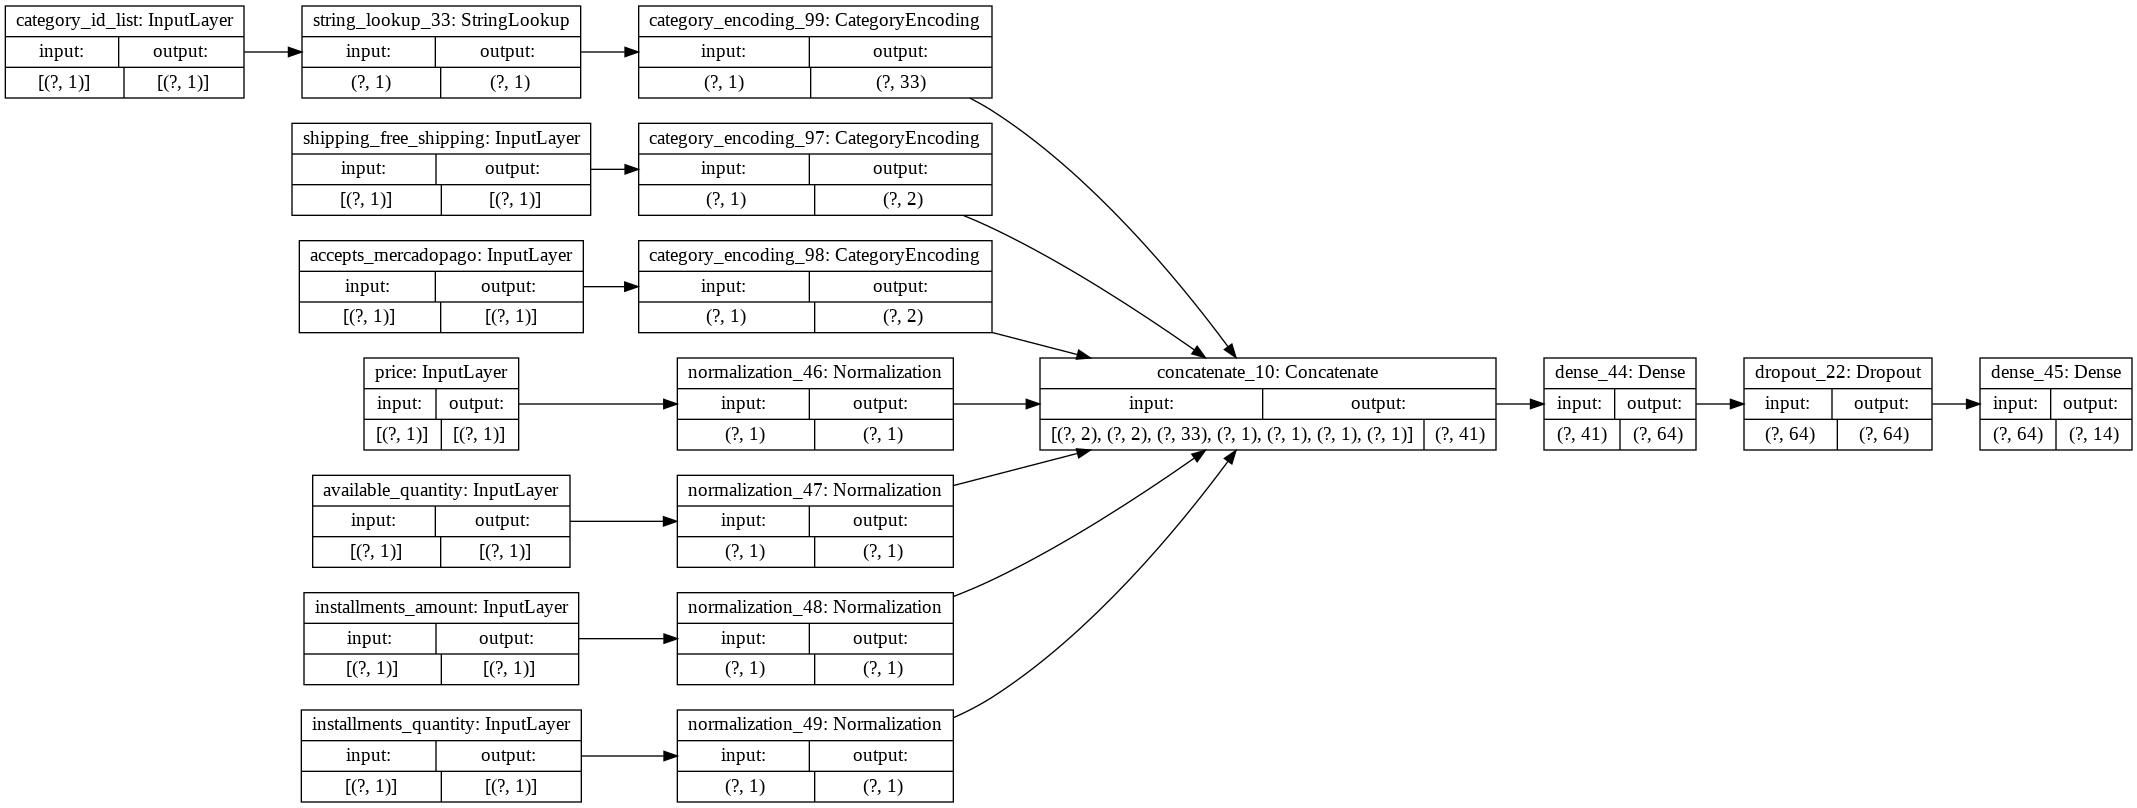

In [ ]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
310/310 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.1320 - val_loss: nan - val_accuracy: 0.1400
Epoch 2/50
310/310 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.1320 - val_loss: nan - val_accuracy: 0.1400
Epoch 3/50
310/310 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.1320 - val_loss: nan - val_accuracy: 0.1400
Epoch 4/50
310/310 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.1320 - val_loss: nan - val_accuracy: 0.1400
Epoch 5/50
310/310 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.1320 - val_loss: nan - val_accuracy: 0.1400
Epoch 6/50
310/310 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.1320 - val_loss: nan - val_accuracy: 0.1400
Epoch 7/50
310/310 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.1320 - val_loss: nan - val_accuracy: 0.1400
Epoch 8/50
310/310 [============================

## 2.1 Modelo xgboost
https://towardsdatascience.com/xgboost-for-multi-class-classification-799d96bcd368

https://github.com/ernestng11/touchpoint-prediction/blob/master/data-cleaning_and_eda.ipynb

https://github.com/ernestng11/touchpoint-prediction/blob/master/model-building.ipynb


In [ ]:
def init_encoder(df, col_names_list):
    d = {}
    for col_name in col_names_list:
        d[col_name] = df[col_name].unique().tolist()
    return d

def one_hot_encoder(df, var_dict):
    for var,vals in var_dict.items():
        for val in vals:
            df[val] = df[var].apply(lambda x: 1 if val in x else 0)
    return df

In [ ]:
model_vars_tb_xb = cat_articulos_1000[['sold_quantity','price', 'category_id_list', 'available_quantity', 'shipping.free_shipping',
                                    'accepts_mercadopago','installments.amount', 'installments.quantity',
                                    #'shipping.logistic_type', 'shipping.store_pick_up' , 
                                    #'condition'			
                                    ]]                                    
model_vars_tb_xb = model_vars_tb_xb.rename(columns={'sold_quantity':'target',
                                              'shipping.free_shipping':'shipping_free_shipping', 'installments.amount':'installments_amount',
                                              'installments.quantity':'installments_quantity'#, 
                                     #         'shipping.logistic_type':'shipping_logistic_type',                                              
                                      #        'shipping.store_pick_up':'shipping_store_pick_up'
                                              })
model_vars_tb_xb.shipping_free_shipping = model_vars_tb_xb.shipping_free_shipping.astype('int')
model_vars_tb_xb.accepts_mercadopago = model_vars_tb_xb.accepts_mercadopago.astype('int')

# from 64 to 32 bits
model_vars_tb_xb.price = np.nan_to_num(model_vars_tb_xb.price.astype(np.float32) )
model_vars_tb_xb.installments_amount = np.nan_to_num(model_vars_tb_xb.installments_amount.astype(np.float32) )
model_vars_tb_xb.installments_quantity = np.nan_to_num(model_vars_tb_xb.installments_quantity.astype(np.float32) )
model_vars_tb_xb.target = np.nan_to_num(model_vars_tb_xb.target.astype(np.int32) )


model_vars_tb_xb.shipping_free_shipping.unique()
print(model_vars_tb_xb.target.unique())
print(model_vars_tb_xb.target.nunique())
model_vars_tb_xb.target
#model_vars_tb_xb

[ 250  500 5000  200  150   50  100   25    5    4    2    3    1    0]
14


0         250
1         500
2         500
3         250
4        5000
         ... 
12388      25
12389       5
12390       5
12391      50
12392       5
Name: target, Length: 12393, dtype: int32

In [ ]:
#create a mapping from labels to a unique integer and vice versa for labelling and prediction later
labels = sorted(model_vars_tb_xb['target'].unique( ))
i = 0
idx2class = {} 
class2idx = {}
for tp in labels:
    idx2class[i] = tp
    class2idx[tp] = i
    i += 1
idx2class
class2idx

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 25: 6,
 50: 7,
 100: 8,
 150: 9,
 200: 10,
 250: 11,
 500: 12,
 5000: 13}

In [ ]:
#df['label'] = df['recent_touchpoint'].replace(class2idx)
model_vars_tb_xb['target'] = model_vars_tb_xb['target'].replace(class2idx)
#model_vars_tb_xb

In [ ]:
# one-hot encoding
d = init_encoder(model_vars_tb_xb,['category_id_list'])
one_hot_encoder(model_vars_tb_xb, d)
#model_vars_tb_xb.to_csv('./mercadolibre-articulos.csv')
model_vars_tb_xb.head(5)
#model_vars_tb_xb.MCO1747.value_counts()

target     price category_id_list  available_quantity  \
0      11   11000.0          MCO1747                 100   
1      12   74900.0          MCO1747                 150   
2      12  189900.0          MCO1747                   1   
3      11   42900.0          MCO1747                  50   
4      13    8500.0          MCO1747                 100   

   shipping_free_shipping  accepts_mercadopago  installments_amount  \
0                       0                    1           305.559998   
1                       1                    1          2080.560059   
2                       1                    1          5275.000000   
3                       0                    1          1191.670044   
4                       0                    1           236.110001   

   installments_quantity  MCO1747  MCO441917  MCO1403  MCO1071  MCO1367  \
0                   36.0        1          0        0        0        0   
1                   36.0        1          0        0        0        0   
2                   36.0        1          0        0        0        0   
3                   36.0        1          0        0        0        0   
4                   36.0        1          0        0        0        0   

   MCO1368  MCO1384  MCO1246  MCO40433  MCO1039  MCO1743  MCO1051  MCO1648  \
0        0        0        0         0        0        0        0        0   
1        0        0        0         0        0        0        0        0   
2        0        0        0         0        0        0        0        0   
3        0        0        0         0        0        0        0        0   
4        0        0        0         0        0        0        0        0   

   MCO1144  MCO1276  MCO5726  MCO1000  MCO175794  MCO1574  MCO1499  MCO1459  \
0        0        0        0        0          0        0        0        0   
1        0        0        0        0          0        0        0        0   
2        0        0        0        0          0        0        0        0   
3        0        0        0        0          0        0        0        0   
4        0        0        0        0          0        0        0        0   

   MCO1182  MCO1132  MCO3025  MCO1168  MCO118204  MCO3937  MCO1430  MCO180800  \
0        0        0        0        0          0        0        0          0   
1        0        0        0        0          0        0        0          0   
2        0        0        0        0          0        0        0          0   
3        0        0        0        0          0        0        0          0   
4        0        0        0        0          0        0        0          0   

   MCO1540  MCO1953  
0        0        0  
1        0        0  
2        0        0  
3        0        0  
4        0        0

In [ ]:
# Normalization: (QuantileTransformer): similar to normalization but it instead uses the interquartile range, so that it is robust to outliers
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal')

In [ ]:
model_vars_tb_xb['price'] = qt.fit_transform(model_vars_tb_xb[['price']].values.reshape(-1,1))
model_vars_tb_xb['installments_amount'] = qt.fit_transform(model_vars_tb_xb[['installments_amount']].values.reshape(-1,1))
model_vars_tb_xb.head(4)

target     price category_id_list  available_quantity  \
0      11 -1.086456          MCO1747                 100   
1      12  0.142245          MCO1747                 150   
2      12  0.647177          MCO1747                   1   
3      11 -0.208505          MCO1747                  50   

   shipping_free_shipping  accepts_mercadopago  installments_amount  \
0                       0                    1            -0.955471   
1                       1                    1             0.033880   
2                       1                    1             0.621099   
3                       0                    1            -0.299230   

   installments_quantity  MCO1747  MCO441917  MCO1403  MCO1071  MCO1367  \
0                   36.0        1          0        0        0        0   
1                   36.0        1          0        0        0        0   
2                   36.0        1          0        0        0        0   
3                   36.0        1          0        0        0        0   

   MCO1368  MCO1384  MCO1246  MCO40433  MCO1039  MCO1743  MCO1051  MCO1648  \
0        0        0        0         0        0        0        0        0   
1        0        0        0         0        0        0        0        0   
2        0        0        0         0        0        0        0        0   
3        0        0        0         0        0        0        0        0   

   MCO1144  MCO1276  MCO5726  MCO1000  MCO175794  MCO1574  MCO1499  MCO1459  \
0        0        0        0        0          0        0        0        0   
1        0        0        0        0          0        0        0        0   
2        0        0        0        0          0        0        0        0   
3        0        0        0        0          0        0        0        0   

   MCO1182  MCO1132  MCO3025  MCO1168  MCO118204  MCO3937  MCO1430  MCO180800  \
0        0        0        0        0          0        0        0          0   
1        0        0        0        0          0        0        0          0   
2        0        0        0        0          0        0        0          0   
3        0        0        0        0          0        0        0          0   

   MCO1540  MCO1953  
0        0        0  
1        0        0  
2        0        0  
3        0        0

Plot for PRICE: total counts = 12393


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



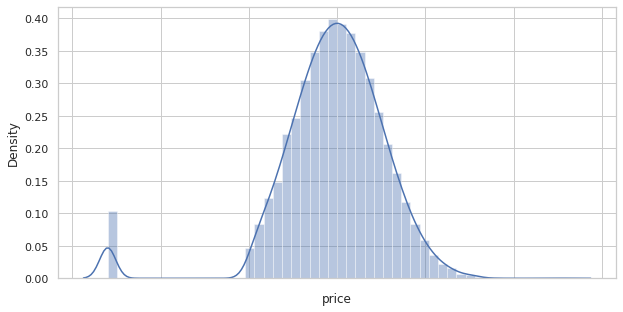

Plot for INSTALLMENTS_AMOUNT: total counts = 12393


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



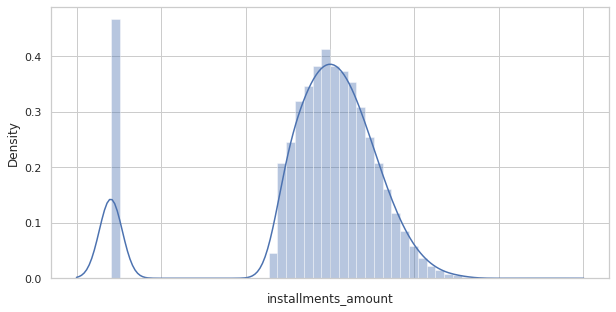

In [ ]:
# distribucion de variables escaladas
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

df_explore = model_vars_tb_xb[['price', 'installments_amount']]
for cat in df_explore:
    cat_num = df_explore[cat]
    print("Plot for %s: total counts = %d" % (cat.upper(), len(cat_num)))
    f, ax = plt.subplots(figsize=(10,5))
    plot = sns.distplot(cat_num)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
    plt.show()

In [ ]:
model_vars_tb_xb['category_id_list'].unique()

array(['MCO1747', 'MCO441917', 'MCO1403', 'MCO1071', 'MCO1367', 'MCO1368',
       'MCO1384', 'MCO1246', 'MCO40433', 'MCO1039', 'MCO1743', 'MCO1051',
       'MCO1648', 'MCO1144', 'MCO1276', 'MCO5726', 'MCO1000', 'MCO175794',
       'MCO1574', 'MCO1499', 'MCO1459', 'MCO1182', 'MCO1132', 'MCO3025',
       'MCO1168', 'MCO118204', 'MCO3937', 'MCO1430', 'MCO180800',
       'MCO1540', 'MCO1953'], dtype=object)

In [ ]:
def stratified_split(df, target, val_percent=0.2):
    '''
    Function to split a dataframe into train and validation sets, while preserving the ratio of the labels in the target variable
    Inputs:
    - df, the dataframe
    - target, the target variable
    - val_percent, the percentage of validation samples, default 0.2
    Outputs:
    - train_idxs, the indices of the training dataset
    - val_idxs, the indices of the validation dataset
    '''
    classes=list(df[target].unique())
    train_idxs, val_idxs = [], []
    for c in classes:
        idx=list(df[df[target]==c].index)
        np.random.shuffle(idx)
        val_size=int(len(idx)*val_percent)
        val_idxs+=idx[:val_size]
        train_idxs+=idx[val_size:]
    return train_idxs, val_idxs


train_idxs, val_idxs = stratified_split(model_vars_tb_xb, 'target', val_percent=0.25)

val_idxs, test_idxs = stratified_split(model_vars_tb_xb[model_vars_tb_xb.index.isin(val_idxs)], 'target', val_percent=0.5)

In [ ]:
def test_stratified(df, col):
    '''
    Analyzes the ratio of different classes in a categorical variable within a dataframe
    Inputs:
    - dataframe
    - categorical column to be analyzed
    Returns: None
    '''
    classes=list(df[col].unique())
    
    for c in classes:
        print(f'Proportion of records with {c}: {len(df[df[col]==c])*1./len(df):0.2} ({len(df[df[col]==c])} / {len(df)})')

In [ ]:
print('---------- STRATIFIED SAMPLING REPORT ----------')
print('-------- Label proportions in FULL data --------')
test_stratified(model_vars_tb_xb, 'target')
print('-------- Label proportions in TRAIN data --------')
test_stratified(model_vars_tb_xb[model_vars_tb_xb.index.isin(train_idxs)], 'target')
print('------ Label proportions in VALIDATION data -----')
test_stratified(model_vars_tb_xb[model_vars_tb_xb.index.isin(val_idxs)], 'target')
print('-------- Label proportions in TEST data ---------')
test_stratified(model_vars_tb_xb[model_vars_tb_xb.index.isin(test_idxs)], 'target')

---------- STRATIFIED SAMPLING REPORT ----------
-------- Label proportions in FULL data --------
Proportion of records with 11: 0.13 (1595 / 12393)
Proportion of records with 12: 0.15 (1861 / 12393)
Proportion of records with 13: 0.004 (49 / 12393)
Proportion of records with 10: 0.046 (564 / 12393)
Proportion of records with 9: 0.057 (705 / 12393)
Proportion of records with 7: 0.11 (1412 / 12393)
Proportion of records with 8: 0.076 (948 / 12393)
Proportion of records with 6: 0.094 (1167 / 12393)
Proportion of records with 5: 0.14 (1675 / 12393)
Proportion of records with 4: 0.013 (160 / 12393)
Proportion of records with 2: 0.017 (215 / 12393)
Proportion of records with 3: 0.015 (188 / 12393)
Proportion of records with 1: 0.016 (198 / 12393)
Proportion of records with 0: 0.13 (1656 / 12393)
-------- Label proportions in TRAIN data --------
Proportion of records with 12: 0.15 (1396 / 9299)
Proportion of records with 11: 0.13 (1197 / 9299)
Proportion of records with 13: 0.004 (37 / 9299)

In [ ]:
#model_vars_tb_xb.price = np.nan_to_num(model_vars_tb_xb.price.astype(np.float32) )
#model_vars_tb_xb.installments_amount = np.nan_to_num(model_vars_tb_xb.installments_amount.astype(np.float32) )
#model_vars_tb_xb.installments_quantity = np.nan_to_num(model_vars_tb_xb.installments_quantity.astype(np.float32) )
#model_vars_tb_xb.target = np.nan_to_num(model_vars_tb_xb.target.astype(np.int32) )

#model_vars_tb_xb.price = model_vars_tb_xb.price.astype(float) 
model_vars_tb_xb.target
#model_vars_tb_xb.columns
#model_vars_tb_xb.price.fillna(value=0)
#model_vars_tb_xb.price.min()

0        11
1        12
2        12
3        11
4        13
         ..
12388     6
12389     5
12390     5
12391     7
12392     5
Name: target, Length: 12393, dtype: int64

In [ ]:
# data split: train - test
train_df = model_vars_tb_xb[model_vars_tb_xb.index.isin(train_idxs)]
X_train = train_df[['price', # 'category_id_list', 
                    'available_quantity',
       'shipping_free_shipping', 'accepts_mercadopago', 'installments_amount',
       'installments_quantity', 
       'MCO1747', 'MCO441917', 'MCO1403', 'MCO1071',
       'MCO1367', 'MCO1368', 'MCO1384', 'MCO1246', 'MCO40433', 'MCO1039',
       'MCO1743', 'MCO1051', 'MCO1648', 'MCO1144', 'MCO1276', 'MCO5726',
       'MCO1000', 'MCO175794', 'MCO1574', 'MCO1499', 'MCO1459', 'MCO1182',
       'MCO1132', 'MCO3025', 'MCO1168', 'MCO118204', 'MCO3937', 'MCO1430',
       'MCO180800', 'MCO1540', 'MCO1953']].values

Y_train = train_df[['target']].values
print('Retrieved Training Data')
val_df = model_vars_tb_xb[model_vars_tb_xb.index.isin(val_idxs)]
X_val = val_df[['price', # 'category_id_list', 
                'available_quantity',
       'shipping_free_shipping', 'accepts_mercadopago',  'installments_amount',
       'installments_quantity', 
       'MCO1747', 'MCO441917', 'MCO1403', 'MCO1071',
       'MCO1367', 'MCO1368', 'MCO1384', 'MCO1246', 'MCO40433', 'MCO1039',
       'MCO1743', 'MCO1051', 'MCO1648', 'MCO1144', 'MCO1276', 'MCO5726',
       'MCO1000', 'MCO175794', 'MCO1574', 'MCO1499', 'MCO1459', 'MCO1182',
       'MCO1132', 'MCO3025', 'MCO1168', 'MCO118204', 'MCO3937', 'MCO1430',
       'MCO180800', 'MCO1540', 'MCO1953']].values
Y_val = val_df[['target']].values

print('Retrieved Validation Data')
test_df = model_vars_tb_xb[model_vars_tb_xb.index.isin(test_idxs)]
X_test = test_df[['price', #'category_id_list',
                  'available_quantity',
       'shipping_free_shipping', 'accepts_mercadopago', 'installments_amount',
       'installments_quantity', 
       'MCO1747', 'MCO441917', 'MCO1403', 'MCO1071',
       'MCO1367', 'MCO1368', 'MCO1384', 'MCO1246', 'MCO40433', 'MCO1039',
       'MCO1743', 'MCO1051', 'MCO1648', 'MCO1144', 'MCO1276', 'MCO5726',
       'MCO1000', 'MCO175794', 'MCO1574', 'MCO1499', 'MCO1459', 'MCO1182',
       'MCO1132', 'MCO3025', 'MCO1168', 'MCO118204', 'MCO3937', 'MCO1430',
       'MCO180800', 'MCO1540', 'MCO1953']].values
Y_test = test_df[['target']].values
print('Retrieved Test Data')

Retrieved Training Data
Retrieved Validation Data
Retrieved Test Data


In [ ]:
#model_vars_tb_xb.MCO1747
#Y_train

array([[250],
       [500],
       [500],
       ...,
       [ 25],
       [ 50],
       [  5]], dtype=int32)

In [ ]:
# model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
#store data, all in numpy arrays
training_data = {'X_train':X_train,'Y_train':Y_train,
                'X_val': X_val,'Y_val':Y_val,
                'X_test': X_test,'Y_test':Y_test}

In [ ]:
training_data = {'X_train':X_train,'Y_train':Y_train,
                'X_val': X_val,'Y_val':Y_val,
                'X_test': X_test,'Y_test':Y_test}
# Random Forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=None,random_state=27, verbose=1)
clf.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=27, verbose=1,
                       warm_start=False)

In [ ]:
predicted_labels = clf.predict(training_data['X_test'])
accuracy_score(training_data['Y_test'], predicted_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


0.3642255346727155

In [ ]:
# grid search
params = {
    'n_estimators'      : range(100,500,50),
    'max_depth'         : [8, 9, 10, 11, 12],
    'max_features': ['auto'],
    'criterion' :['gini']
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch1 = GridSearchCV(estimator = clf, param_grid = params, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch1.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

In [ ]:
getTrainScores(gsearch1)

In [ ]:
clf2 = gsearch1.best_estimator_

params1 = {
    'n_estimators'      : range(200,300,10),
    'max_depth'         : [11, 12,13]
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch2 = GridSearchCV(estimator = clf2, param_grid = params1, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch2.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

In [ ]:
getTrainScores(gsearch2)

In [ ]:
clf3 = gsearch2.best_estimator_

params2 = {
    'n_estimators'      : range(200,220,5),
    'max_depth'         : [13,14,15]
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch3 = GridSearchCV(estimator = clf3, param_grid = params2, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch3.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

In [ ]:
getTrainScores(gsearch3)

In [ ]:
clf4 = gsearch3.best_estimator_

params3 = {
    'max_depth'         : range(14,20,1)
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch4 = GridSearchCV(estimator = clf4, param_grid = params3, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch4.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

In [ ]:
getTrainScores(gsearch4)

In [ ]:
clf5 = gsearch4.best_estimator_

params4 = {
    'max_depth'         : range(19,50,2)
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch5 = GridSearchCV(estimator = clf5, param_grid = params4, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch5.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

In [ ]:
getTrainScores(gsearch5)

In [ ]:
clf6 = gsearch5.best_estimator_

params5 = {
    'max_depth'         : [24,25,26]
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch6 = GridSearchCV(estimator = clf6, param_grid = params5, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch6.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

In [ ]:
getTrainScores(gsearch6)

In [ ]:
final_clf = gsearch6.best_estimator_

In [ ]:
final_clf.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))
predicted_labels = final_clf.predict(training_data['X_test'])
train_pred = final_clf.predict(training_data['X_train'])
print('Train Accuracy:'+str(accuracy_score(training_data['Y_train'], train_pred)))
print('Train F1-Score(Micro):'+str(f1_score(training_data['Y_train'], train_pred,average='micro')))
print('------')
print('Test Accuracy:'+str(accuracy_score(training_data['Y_test'], predicted_labels)))
print('Test F1-Score(Micro):'+str(f1_score(training_data['Y_test'], predicted_labels,average='micro')))

In [ ]:

f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y=final_clf.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

## 2.2 Model Xgboost

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

#allow logloss and classification error plots for each iteraetion of xgb model
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
        
def fitXgb(sk_model, training_data=training_data,epochs=100):
    print('Fitting model...')
    sk_model.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))
    print('Fitting done!')
    train = xgb.DMatrix(training_data['X_train'], label=training_data['Y_train'])
    val = xgb.DMatrix(training_data['X_val'], label=training_data['Y_val'])
    params = sk_model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(val, 'val'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=100)
    print('-- Model Report --')
    print('XGBoost Accuracy: '+str(accuracy_score(sk_model.predict(training_data['X_test']), training_data['Y_test'])))
    print('XGBoost F1-Score (Micro): '+str(f1_score(sk_model.predict(training_data['X_test']),training_data['Y_test'],average='micro')))
    plot_compare(metrics,store,epochs)
    features = ['price', # 'category_id_list', 
                'available_quantity',
       'shipping_free_shipping', 'accepts_mercadopago',  'installments_amount',
       'installments_quantity', 
       'MCO1747', 'MCO441917', 'MCO1403', 'MCO1071',
       'MCO1367', 'MCO1368', 'MCO1384', 'MCO1246', 'MCO40433', 'MCO1039',
       'MCO1743', 'MCO1051', 'MCO1648', 'MCO1144', 'MCO1276', 'MCO5726',
       'MCO1000', 'MCO175794', 'MCO1574', 'MCO1499', 'MCO1459', 'MCO1182',
       'MCO1132', 'MCO3025', 'MCO1168', 'MCO118204', 'MCO3937', 'MCO1430',
       'MCO180800', 'MCO1540', 'MCO1953']
    f, ax = plt.subplots(figsize=(10,5))
    plot = sns.barplot(x=features, y=sk_model.feature_importances_)
    ax.set_title('Feature Importance')
    plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
    plt.show()

In [ ]:
from xgboost.sklearn import XGBClassifier
#initial model
xgb1 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    nthread=2,
                    num_class=14,
                    seed=27)

In [ ]:
#training_data
training_data = {'X_train':X_train,'Y_train':Y_train,
                'X_val': X_val,'Y_val':Y_val,
                'X_test': X_test,'Y_test':Y_test}

Fitting model...
Fitting done!
[0]	val-mlogloss:2.50871	val-merror:0.641522	train-mlogloss:2.50121	train-merror:0.628992
[99]	val-mlogloss:1.60404	val-merror:0.578337	train-mlogloss:1.36527	train-merror:0.477363
-- Model Report --
XGBoost Accuracy: 0.38885288399222295
XGBoost F1-Score (Micro): 0.38885288399222295


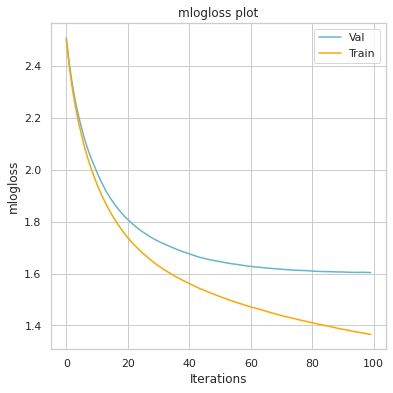

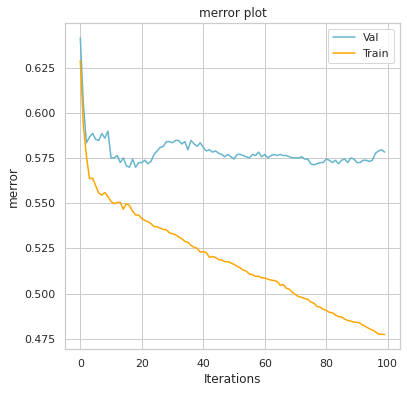

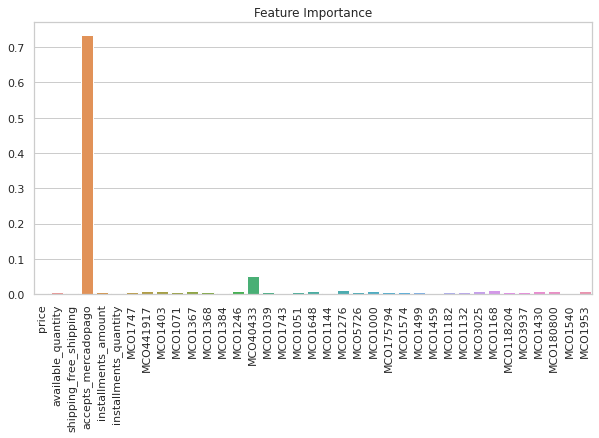

In [ ]:
fitXgb(xgb1, training_data)

In [ ]:
# Tune max_depth and min_child_weight
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch1.fit(X_train, Y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   18.3s


KeyboardInterrupt: ignored

In [ ]:
getTrainScores(gsearch1)

In [ ]:
xgb2 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=9,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=9,
                    seed=27)

fitXgb(xgb2, training_data)

In [ ]:
param_test2 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch2 = GridSearchCV(estimator = xgb2, param_grid = param_test2, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=3)
gsearch2.fit(X_train, Y_train)

In [ ]:
getTrainScores(gsearch2)

xgb3 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=9,
                    min_child_weight=1,
                    reg_alpha=0.01,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=9,
                    seed=27)

fitXgb(xgb3, training_data)

In [ ]:
# Model Deploy
import pickle

pickl = {'model': xgb3}
pickle.dump(pickl, open('model_file'+'.p','wb'))

In [ ]:
file_name = 'model_file.p'
with open(file_name,'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

In [ ]:
#input transformed values to make a prediction in FlaskAPI
model.predict(X_test[4,:].reshape(1,-1))

## 2.3 Similarity

In [ ]:
import string
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
model_vars_tb_xb

NameError: ignored

In [ ]:
#cat_price = cat_articulos_1000_2[['price','category_id', 'domain_id']]
#cat_price
#fig = px.box(cat_price, x="domain_id", y="price", color="domain_id", title="Long-Form Input")
#fig.show()
from plotly.subplots import make_subplots

fig = make_subplots(rows=6, cols=6)
px.histogram(cat_articulos_1000_4, x="price", facet_col='category_name', nbins=200)

In [ ]:
#import seaborn as sns
#cat_price = cat_articulos_1000[['price', 'category_id']]
#df = pd.DataFrame(cat_articulos_1000.price, columns=list(cat_articulos_1000.category_id))
#df.boxplot(return_type='axes');

#cat_price.boxplot(by ='category_id', column =['price'], grid = False, rot=90, fontsize=10, figsize=(15,10)) 
#sns.boxplot(x = 'category_id', y = 'price', data = cat_price) 

In [ ]:
import plotly.express as px
#long_df = px.data.medals_long()

fig = px.bar(cat_price, x="category_id", y="price", color="category_id", title="Long-Form Input")
fig.show()

In [ ]:
fig = px.box(cat_price, x="category_id", y="price", color="category_id", title="Long-Form Input")
fig.show()

In [ ]:
long_df

nation   medal  count
0  South Korea    gold     24
1        China    gold     10
2       Canada    gold      9
3  South Korea  silver     13
4        China  silver     15
5       Canada  silver     12
6  South Korea  bronze     11
7        China  bronze      8
8       Canada  bronze     12

In [ ]:
#cat_articulos_1000
import plotly.express as px
df = px.data.tips()
type(df.sex)
type(cat_articulos_1000.category_id)
#cat_articulos_1000.category_id
#fig = px.histogram(df, x="total_bill", color="sex")
#fig.show()

pandas.core.series.Series

In [ ]:
cat_articulos_1000.groupby('category_id')['price'].sum()

category_id
MCO10203       149000.0
MCO10209       143900.0
MCO10271        21990.0
MCO10281        89980.0
MCO1042     128767902.0
               ...     
MCO92657            0.0
MCO92679           30.0
MCO92680        75990.0
MCO9355        547394.0
MCO9356        725762.0
Name: price, Length: 917, dtype: float64

In [ ]:
import plotly.express as px
#df = px.data.tips()
#fig = px.histogram(cat_articulos_1000, x="price", facet_row='category_id')
#fig.show()

#fig = px.box(cat_articulos_1000, y="price", facet_col="category_id", color="category_id",
#             boxmode="overlay")
fig = px.box(cat_articulos_1000, y="price", facet_col="category_id", #color="category_id",
             boxmode="overlay")

fig.show()

ValueError: 
    Invalid value of type 'builtins.float' received for the 'domain[1]' property of layout.xaxis
        Received value: -0.018887677208287896

    The 'domain[1]' property is a number and may be specified as:
      - An int or float in the interval [0, 1]

In [ ]:
import plotly.figure_factory as ff
import numpy as np
import pandas as pd

df = pd.DataFrame({'2012': np.random.randn(200),
                   '2013': np.random.randn(200)+1})
fig = ff.create_distplot([df[c] for c in df.columns], df.columns, bin_size=.25)
fig.show()


In [ ]:
import plotly.express as px
#df = px.data.tips()
#cat_articulos_1000.title
fig = px.histogram(cat_articulos_1000, x="price", color="category_id", range_x=[0, int(5e6)], nbins=100 )
fig.show()
#fig = px.histogram(cat_articulos_1000, x="price", y="tip", color="sex", facet_row="time", facet_col="day",
#       category_orders={"day": ["Thur", "Fri", "Sat", "Sun"], "time": ["Lunch", "Dinner"]})
#fig.show()

In [ ]:
import plotly.express as px
df = px.data.tips()
#df.tips
fig = px.histogram(df, x="total_bill", y="tip", color="sex", facet_row="time", facet_col="day",
       category_orders={"day": ["Thur", "Fri", "Sat", "Sun"], "time": ["Lunch", "Dinner"]})
fig.show()

In [ ]:

import plotly.express as px  
import plotly.graph_objects as go  
    
#df = px.data.iris()  
    
fig = go.Figure(data=[go.Histogram(x=cat_articulos_1000.price,  
                                   cumulative_enabled=True)])  
fig.show()


In [ ]:

import chart_studio as py
from plotly.graph_objs import *

trace1 = {
  "name": "Count", 
  "type": "bar", 
  "x": ["Too Many Consecutives Suspicious Parts", "M/C Waiting End Of Cycle", "Machine Stopped By Vision System", "M/C Running...", "End Of Extrusion At Entrance", "Loop Control Fault", "Emergency Stop Activated", "Vibrating Bowl #1 Fault", "M/C Stop, Ready To Start", "Batch Counter Reached", "Hopper #1 Empty", "End Sensing Result Not Valid", "Machine Not At Initial Position", "Part Jammed At Exit", "End Sensing Flag Move Fault", "Hopper #2 Empty", "M/C Initializing", "Vibrating Bowl #2 Fault", "Safety Relay (MSR1) Not Activated", "Initialisation Sequence Timeout", "Clip Missing From Bowl#1", "Ejection Conveyor Front Door Fault", "Ejection Conveyor Rear Door Fault", "Extrusion Jammed At Entrance", "M/C Not Initialized", "Safety Door(s) Locking Fault", "Clip Missing From Bowl#2", "End Sensing End Of Cycle", "Machine Not ady To Start", "Machine StopEnd Of Cycle����������������"], 
  "y": [840, 541, 492, 482, 370, 218, 200, 176, 169, 128, 116, 74, 68, 50, 27, 18, 17, 17, 16, 15, 8, 8, 6, 6, 5, 2, 1, 1, 1, 1], 
  "marker": {"color": "rgb(34,163,192)"}
}
trace2 = {
  "line": {
    "color": "rgb(243,158,115)", 
    "width": 2.4
  }, 
  "name": "Cumulative Percentage", 
  "type": "scatter", 
  "x": ["Too Many Consecutives Suspicious Parts", "M/C Waiting End Of Cycle", "Machine Stopped By Vision System", "M/C Running...", "End Of Extrusion At Entrance", "Loop Control Fault", "Emergency Stop Activated", "Vibrating Bowl #1 Fault", "M/C Stop, Ready To Start", "Batch Counter Reached", "Hopper #1 Empty", "End Sensing Result Not Valid", "Machine Not At Initial Position", "Part Jammed At Exit", "End Sensing Flag Move Fault", "Hopper #2 Empty", "M/C Initializing", "Vibrating Bowl #2 Fault", "Safety Relay (MSR1) Not Activated", "Initialisation Sequence Timeout", "Clip Missing From Bowl#1", "Ejection Conveyor Front Door Fault", "Ejection Conveyor Rear Door Fault", "Extrusion Jammed At Entrance", "M/C Not Initialized", "Safety Door(s) Locking Fault", "Clip Missing From Bowl#2", "End Sensing End Of Cycle", "Machine Not ady To Start", "Machine StopEnd Of Cycle����������������"], 
  "y": [20.623618954087895, 33.90621163761355, 45.98575988215075, 57.819788853424996, 66.90400196415419, 72.25632212128652, 77.16670758654554, 81.48784679597348, 85.63712251411737, 88.77976921188313, 91.62779278173336, 93.4446354038792, 95.11416646206727, 96.34176282838203, 97.004664866192, 97.4465995580653, 97.86398232261233, 98.28136508715934, 98.67419592438006, 99.04247483427449, 99.23889025288486, 99.43530567149521, 99.58261723545299, 99.72992879941076, 99.85268843604223, 99.90179229069481, 99.92634421802111, 99.95089614534741, 99.9754480726737, 100.0], 
  "yaxis": "y2"
}
trace3 = {
  "line": {
    "dash": "dash", 
    "color": "rgba(128,128,128,.45)", 
    "width": 1.5
  }, 
  "name": "80%", 
  "type": "scatter", 
  "x": ["Too Many Consecutives Suspicious Parts", "M/C Waiting End Of Cycle", "Machine Stopped By Vision System", "M/C Running...", "End Of Extrusion At Entrance", "Loop Control Fault", "Emergency Stop Activated", "Vibrating Bowl #1 Fault", "M/C Stop, Ready To Start", "Batch Counter Reached", "Hopper #1 Empty", "End Sensing Result Not Valid", "Machine Not At Initial Position", "Part Jammed At Exit", "End Sensing Flag Move Fault", "Hopper #2 Empty", "M/C Initializing", "Vibrating Bowl #2 Fault", "Safety Relay (MSR1) Not Activated", "Initialisation Sequence Timeout", "Clip Missing From Bowl#1", "Ejection Conveyor Front Door Fault", "Ejection Conveyor Rear Door Fault", "Extrusion Jammed At Entrance", "M/C Not Initialized", "Safety Door(s) Locking Fault", "Clip Missing From Bowl#2", "End Sensing End Of Cycle", "Machine Not ady To Start", "Machine StopEnd Of Cycle����������������"], 
  "y": [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80], 
  "yaxis": "y2"
}
data = Data([trace1, trace2, trace3])
layout = {
  "font": {
    "size": 12, 
    "color": "rgb(128,128,128)", 
    "family": "Balto, sans-serif"
  }, 
  "title": "Diagram Pareto ", 
  "width": 1500, 
  "xaxis": {"tickangle": -90}, 
  "yaxis": {
    "range": [0, 30300], 
    "title": "Count", 
    "tickfont": {"color": "rgba(34,163,192,.75)"}, 
    "tickvals": [0, 6000, 12000, 18000, 24000, 30000], 
    "titlefont": {
      "size": 14, 
      "color": "rgba(34,163,192,.75)", 
      "family": "Balto, sans-serif"
    }
  }, 
  "height": 623, 
  "legend": {
    "x": 0.83, 
    "y": 1.3, 
    "font": {
      "size": 12, 
      "color": "rgba(128,128,128,.75)", 
      "family": "Balto, sans-serif"
    }
  }, 
  "margin": {
    "b": 250, 
    "l": 60, 
    "r": 60, 
    "t": 65
  }, 
  "yaxis2": {
    "side": "right", 
    "range": [0, 101], 
    "tickfont": {"color": "rgba(243,158,115,.9)"}, 
    "tickvals": [0, 20, 40, 60, 80, 100], 
    "overlaying": "y"
  }, 
  "hovermode": "compare", 
  "titlefont": {
    "size": 0, 
    "color": "", 
    "family": ""
  }, 
  "showlegend": True, 
  "annotations": [
    {
      "x": 1.029, 
      "y": 0.75, 
      "font": {
        "size": 14, 
        "color": "rgba(243,158,115,.9)", 
        "family": "Balto, sans-serif"
      }, 
      "text": "Cumulative Percentage", 
      "xref": "paper", 
      "yref": "paper", 
      "showarrow": False, 
      "textangle": 90
    }
  ], 
  "plot_bgcolor": "rgb(240, 240, 240)", 
  "paper_bgcolor": "rgb(240, 240, 240)"
}
fig = Figure(data=data, layout=layout)
plot_url = py.plot(fig)

/home/m66/virtual-envs-python/v-mercadolibre/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:40: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




ValueError: 
    Invalid value of type 'builtins.str' received for the 'hovermode' property of layout
        Received value: 'compare'

    The 'hovermode' property is an enumeration that may be specified as:
      - One of the following enumeration values:
            ['x', 'y', 'closest', False, 'x unified', 'y unified']

<AxesSubplot:>

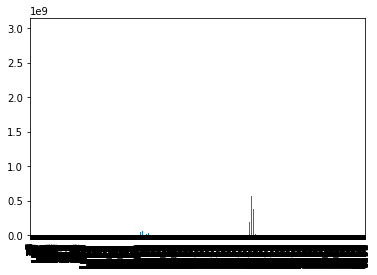

In [ ]:
cat_articulos_1000.price.plot(kind='bar')

<AxesSubplot:title={'center':'price'}, xlabel='category_id'>

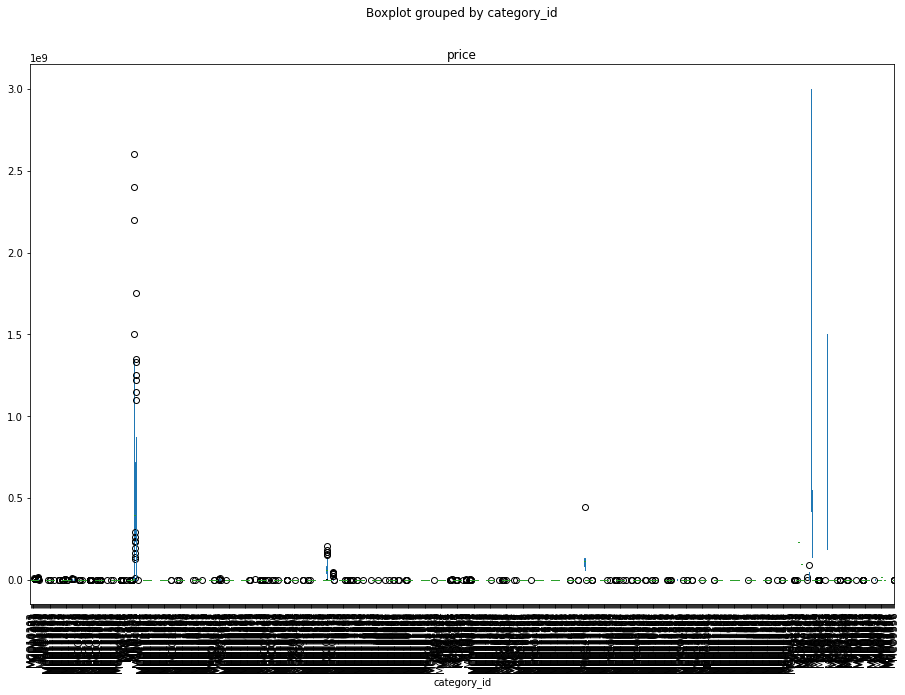

In [ ]:
import seaborn as sns
cat_price = cat_articulos_1000[['price', 'category_id']]
#df = pd.DataFrame(cat_articulos_1000.price, columns=list(cat_articulos_1000.category_id))
#df.boxplot(return_type='axes');

cat_price.boxplot(by ='category_id', column =['price'], grid = False, rot=90, fontsize=10, figsize=(15,10)) 
#sns.boxplot(x = 'category_id', y = 'price', data = cat_price) 

#df = pd.DataFrame(np.random.randn(100, 5), columns=list('ABCDE'))

#df.boxplot(return_type='axes');

#cat_price.plot.box()
#df.boxplot(col='X')
#cat_price.boxplot(col='category_id')
#cat_price.pivot(columns = 'category_id', values = 'price')
#return_type='axes'
#cat_price.boxplot(return_type='axes')

In [ ]:
df

A         B         C         D         E
0   1.290221 -2.102383 -0.739327 -0.111626  1.118587
1  -0.459330 -0.313721  0.997546  0.977454 -0.081823
2   0.464275  0.302073  0.383433  0.423116  1.067832
3  -0.857284  2.020345  0.678949 -0.506636  0.232225
4  -0.135659 -1.901680  0.757240 -1.082962  0.482755
..       ...       ...       ...       ...       ...
95 -0.692106  0.841815  0.299162 -0.729177  0.493057
96 -0.030499 -0.628367  2.297716 -0.969512  0.013010
97  0.616192  1.388169 -0.595933  0.261815  0.619678
98 -0.256916 -0.685372 -0.142581  0.790196  0.432639
99 -1.350818  0.292411 -0.688881 -1.091286  0.591604

[100 rows x 5 columns]